# **Insights into Urban Dynamics:** Analyzing Airbnb Reviews and Neighborhood Metrics
---
### Project Overview

This study aims to investigate the correlation between subjective Airbnb reviews and objective neighborhood metrics in select US cities. It involves analyzing crime statistics, demographics, socioeconomic indicators, and environmental quality to understand how they relate to sentiments expressed in Airbnb reviews.

In contrast to prevailing research, which predominantly focuses on property-specific details, our approach transcends these limitations. Drawing inspiration from the comprehensive nature of Airbnb reviews, recognized for their substantive content, our study endeavors to decode broader perceptions and conditions pertaining to neighborhoods (Zhang et al., 2020). We aim to leverage location data embedded in these reviews, establishing a robust connection between subjective expressions and the tangible characteristics of urban development.

Our hypothesis centers on the potential of location data to serve as a conduit, facilitating the linkage between subjective impressions articulated in reviews and the substantive attributes defining urban landscapes. This methodological innovation holds considerable promise for systematically evaluating the correlation between nuanced perceptions and the empirical characteristics of urban environments. Through this inquiry, our goal is to contribute academically rigorous insights into unraveling the intricate interplay between subjective experiences and the objective realities of urban spaces.

---
### Objectives

- Investigate correlations between subjective reviews and quantifiable rental property and neighborhood attributes in targeted US cities.
- Understand how guest experiences align with tangible neighborhood characteristics.
---
### Methodologies and Tools

- **Data Collection**: Utilize Python libraries (e.g., Pandas, Requests) for data collection and preprocessing.
- **Sentiment Analysis**: Implement TextBlob for sentiment analysis of Airbnb reviews and consider numerical ratings.
- **Visualization**: Use Matplotlib,Plotly,Seaborn for visual representation of relationships.
- **Correlation Techniques**: Employ regression analysis, correlation coefficients and other analysis techniques(cluster, principle component, etc.)

---
### Data Sources
We extracted data from: 
- **Inside Airbnb for listings and reviews**
http://insideairbnb.com/get-the-data/
- **Unemployment Rate**
https://www.kaggle.com/datasets/jayrav13/unemployment-by-county-us/data
- Cost of Living - *not using*
https://www.kaggle.com/code/eugeniokukes/us-cost-of-living/notebook
- **Census/Demographics**
https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data
- **Gun Deaths**
https://www.kaggle.com/datasets/ahmedeltom/us-gun-deaths-by-county-19992019
- **Cost of Living by State**
https://advisorsmith.com/data/coli/#data
- **Crime Data by City**
https://advisorsmith.com/data/coli/#data
- Air Quality = *not using*
https://www.epa.gov/healthresearch/environmental-quality-index-eqi
- **Average temps**
https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities


---

# **DATA CLEANING**

## **Import dependencies**

In [14]:
!pip install seaborn matplotlib
!pip install scikit-learn
!pip install textblob
!python -m textblob.download_corpora
!pip install geopandas

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\gdougherty\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gdougherty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gdougherty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gdougherty\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\gdougherty\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\gdougherty\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_

Finished.
Could not fetch URL https://pypi.org/simple/geopandas/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/geopandas/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1131)'))) - skipping


ERROR: Could not find a version that satisfies the requirement geopandas (from versions: none)
ERROR: No matching distribution found for geopandas


In [15]:
import pandas as pd
import requests
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
import zipfile
import geopandas as gpd
import glob

ModuleNotFoundError: No module named 'geopandas'

## **Airbnb listings**

### Examine individual listings dfs

In [96]:
seattle_listings = pd.read_csv('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/listings.csv.gz')

In [97]:
seattle_listings['neighbourhood'].unique()

array(['Seattle, Washington, United States', nan,
       'Ballard, Seattle, Washington, United States',
       'West Seattle, Washington, United States',
       'Ballard Seattle, Washington, United States',
       'Capitol Hill, Seattle, Washington, United States',
       'Seattle, United States',
       'West Seattle, Washington, Washington, United States',
       'Seattle, Wa, United States',
       'Shoreline, Washington, United States',
       'Seattle , Washington, United States',
       'Lake Forest Park, Washington, United States'], dtype=object)

In [99]:
seattle_listings = pd.read_csv('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/listings.csv.gz')
la_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/listings.csv.gz')
nyc_listings = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/listings.csv.gz')

### Create large df that includes all 3 cities sets

In [36]:
import pandas as pd

# function to add the city_name column
def read_and_add_city_column(city_url, city_name):
    # Read the CSV file into a DataFrame
    city_listings = pd.read_csv(city_url)
    # Add a 'City' column to the DataFrame indicating the source city
    city_listings['City'] = city_name
    return city_listings

# Function to concatenate DataFrames and retain the 'City' column
def concatenate_listings_dataframes(*dfs):
    for df in dfs:
        if 'City' not in df.columns:
            raise ValueError("Missing 'City' column in one of the DataFrames")
    concatenated_df = pd.concat(dfs, ignore_index=True)
    return concatenated_df

# URL and city names
cities_info = [
    ('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/listings.csv.gz', 'Seattle'),
    ('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/listings.csv.gz','LA'),
    ('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/listings.csv.gz','NYC'),
    ]

# Read each city's listings and add 'City' column
city_dfs = []
for url, city in cities_info:
    city_df = read_and_add_city_column(url, city)
    city_dfs.append(city_df)

# Concatenate the DataFrames and create the 'all_listings' DataFrame
all_listings = concatenate_listings_dataframes(*city_dfs)

In [37]:
all_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [38]:
#rename city column to make it clear it's from the listings files
all_listings.rename(columns={'City': 'listing_city'}, inplace=True)

### Clean Airbnb listing dataframe and save cleaned_listings dataframe as .csv

In [103]:
all_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,listings_city
0,6606,https://www.airbnb.com/rooms/6606,20230918050357,2023-09-18,city scrape,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...",https://a0.muscache.com/pictures/45742/21116d7...,14942,...,4.88,4.57,str-opli-19-002622,f,2,2,0,0,0.93,Seattle
1,9419,https://www.airbnb.com/rooms/9419,20230918050357,2023-09-18,city scrape,Rental unit in Seattle · ★4.72 · 1 bedroom · 1...,"Keeping you safe is our priority, we are adher...","Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,...,4.66,4.65,STR-OPLI-19-003039,f,9,0,9,0,1.21,Seattle
2,9531,https://www.airbnb.com/rooms/9531,20230918050357,2023-09-18,city scrape,Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,https://a0.muscache.com/pictures/30470355/052c...,31481,...,4.97,4.91,STR-OPLI-19-002182,f,2,2,0,0,0.54,Seattle
3,9534,https://www.airbnb.com/rooms/9534,20230918050357,2023-09-18,city scrape,Guest suite in Seattle · ★4.99 · 2 bedrooms · ...,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,https://a0.muscache.com/pictures/30476721/0751...,31481,...,4.96,4.95,STR-OPLI-19-002182,f,2,2,0,0,0.53,Seattle
4,9596,https://www.airbnb.com/rooms/9596,20230918050357,2023-09-18,previous scrape,Rental unit in Seattle · ★4.56 · 1 bedroom · 4...,"We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...",https://a0.muscache.com/pictures/665252/102d18...,14942,...,4.91,4.56,STR -OPLI-19-002622,f,2,2,0,0,0.65,Seattle


In [39]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136015 entries, 0 to 136014
Data columns (total 76 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            136015 non-null  int64  
 1   listing_url                                   136015 non-null  object 
 2   scrape_id                                     136015 non-null  int64  
 3   last_scraped                                  136015 non-null  object 
 4   source                                        136015 non-null  object 
 5   name                                          136015 non-null  object 
 6   description                                   134567 non-null  object 
 7   neighborhood_overview                         83424 non-null   object 
 8   picture_url                                   136014 non-null  object 
 9   host_id                                       13

In [105]:
#Check for null values in the listing dataset
null_percentage = (all_listings.isna().mean() * 100).round(2).sort_values(ascending=False)
print(null_percentage)

calendar_updated          100.00
bathrooms                 100.00
license                    73.32
host_about                 40.54
neighborhood_overview      38.67
                           ...  
minimum_minimum_nights      0.00
maximum_minimum_nights      0.00
minimum_maximum_nights      0.00
maximum_maximum_nights      0.00
listings_city               0.00
Length: 76, dtype: float64


In [42]:
def clean_listings_file(df, columns_to_drop=None):
    """
    Clean a listings DataFrame by dropping specified columns and those containing 'host' or 'availability' in their names.

    Parameters:
    - df (DataFrame): The DataFrame to be cleaned.
    - columns_to_drop (list, optional): A list of columns to be dropped. Default is None.

    Returns:
    - DataFrame: A cleaned DataFrame with columns dropped based on criteria:
        - Columns with >50% NA values are dropped.
        - Columns containing 'host' in their names are considered not relevant to actual listing.
        - Additional columns specified in 'columns_to_drop' are dropped if provided.
        - Columns related to availability of listings are dropped.

    Note:
    - 'columns_to_drop' parameter allows the user to specify additional columns to drop.
    - Columns with >50% NA values and those related to 'host' or 'availability' are automatically considered for dropping.
    """
    # Drop columns with >50% NA
    threshold = len(df) * 0.5  # 50% threshold
    df = df.dropna(thresh=threshold, axis=1)

    # Identify columns containing 'host' in their names, not relevent to actual listing
    host_columns = [col for col in df.columns if 'host' in col]
        
    # Initialize cols_to_drop if not provided
    if columns_to_drop is None:
        columns_to_drop = []

    # Combine all columns to drop
    cols_to_drop = columns_to_drop + host_columns

    # Filter the columns that actually exist in the DataFrame
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]

    # Drop columns with 'availability' in the column name - availability of listing not relevent
    availability_columns = df.filter(like='availability').columns.tolist()
    cols_to_drop += availability_columns

    # Drop columns from the DataFrame
    df = df.drop(cols_to_drop, axis=1)
    
    return df



specified_columns = [
    'listing_url', 'scrape_id', 'source',
     'picture_url','license', 'amenities'
]

cleaned_all_listings = clean_listings_file(all_listings.copy(), specified_columns)


In [44]:
cleaned_all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136015 entries, 0 to 136014
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            136015 non-null  int64  
 1   last_scraped                  136015 non-null  object 
 2   name                          136015 non-null  object 
 3   description                   134567 non-null  object 
 4   neighborhood_overview         83424 non-null   object 
 5   neighbourhood                 83427 non-null   object 
 6   neighbourhood_cleansed        136015 non-null  object 
 7   neighbourhood_group_cleansed  90577 non-null   object 
 8   latitude                      136015 non-null  float64
 9   longitude                     136015 non-null  float64
 10  property_type                 136015 non-null  object 
 11  room_type                     136015 non-null  object 
 12  accommodates                  136015 non-nul

In [45]:
cleaned_all_listings['bathrooms_text'].unique()

array(['1 bath', '3 shared baths', '1.5 baths', '4 shared baths',
       '1 shared bath', '3 baths', '2 baths', '1 private bath',
       '2.5 baths', '1.5 shared baths', 'Shared half-bath',
       '2 shared baths', '3.5 baths', '4 baths', 'Half-bath',
       '2.5 shared baths', '3.5 shared baths', '0 shared baths',
       '4.5 baths', '16 shared baths', '0 baths', '6 baths',
       'Private half-bath', '6.5 baths', '7 baths', '5.5 baths',
       '5 baths', '10 baths', nan, '8 baths', '9.5 baths', '9 baths',
       '5 shared baths', '11 shared baths', '7.5 baths', '8.5 baths',
       '13.5 baths', '8 shared baths', '27 baths', '8.5 shared baths',
       '11.5 shared baths', '7 shared baths', '12 baths', '24 baths',
       '4.5 shared baths', '11 baths', '11.5 baths', '15 baths',
       '6 shared baths', '14 shared baths', '16 baths', '10 shared baths',
       '10.5 baths', '21 baths', '17 baths', '36 baths',
       '5.5 shared baths', '12.5 baths', '13 baths', '25 baths',
       '9 shar

In [46]:
#create numerical column for # of bathrooms
def clean_text_values(value):
    if pd.isnull(value):
        return np.nan

    # Extract numerical values
    numeric_val = re.findall(r'\d+\.*\d*', str(value))
    
    # Return the first numerical value found (in case function is used on text that contains multiple)
    if numeric_val:
        return float(numeric_val[0])
    else:
        return np.nan

cleaned_all_listings['num_bathrooms'] = cleaned_all_listings['bathrooms_text'].apply(clean_text_values)
cleaned_all_listings.drop(columns='bathrooms_text', inplace=True)

In [47]:
#confrim removal of all null values
cleaned_all_listings.isna().any()

id                              False
last_scraped                    False
name                            False
description                      True
neighborhood_overview            True
neighbourhood                    True
neighbourhood_cleansed          False
neighbourhood_group_cleansed     True
latitude                        False
longitude                       False
property_type                   False
room_type                       False
accommodates                    False
bedrooms                         True
beds                             True
price                           False
minimum_nights                  False
maximum_nights                  False
minimum_minimum_nights          False
maximum_minimum_nights          False
minimum_maximum_nights          False
maximum_maximum_nights          False
minimum_nights_avg_ntm          False
maximum_nights_avg_ntm          False
calendar_last_scraped           False
number_of_reviews               False
number_of_re

In [48]:
#clean 'instant_bookable' so it's not string
cleaned_all_listings['instant_bookable'].replace({'f': 0, 't': 1}, inplace=True)

In [49]:
# changing and converting data types for price
cleaned_all_listings['price'] = cleaned_all_listings['price'].replace('[\$,]', '', regex=True).astype(float)

In [113]:
#remove listings/rows with na -- dropped full cities: only Seattle, LA and NYC left
cleaned_all_listings.dropna(inplace=True)

In [114]:
cleaned_all_listings.head()

,id,last_scraped,name,description,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listings_city,num_bathrooms
0,6606,2023-09-18,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,...,4.67,4.67,4.83,4.76,4.88,4.57,0,0.93,Seattle,1.0
2,9531,2023-09-18,Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55495,-122.38663,...,4.99,4.97,4.99,4.96,4.97,4.91,0,0.54,Seattle,1.0
3,9534,2023-09-18,Guest suite in Seattle · ★4.99 · 2 bedrooms · ...,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55627,-122.38607,...,4.99,4.99,5.00,4.99,4.96,4.95,0,0.53,Seattle,1.0
4,9596,2023-09-18,Rental unit in Seattle · ★4.56 · 1 bedroom · 4...,"We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65608,-122.33602,...,4.55,4.50,4.80,4.66,4.91,4.56,0,0.65,Seattle,1.0
5,9909,2023-09-18,Home in Seattle · ★4.80 · 2 bedrooms · 2 beds ...,Our two-bedroom home is nestled in a quiet nei...,The Luna Park neighborhood is located just a f...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.56612,-122.37273,...,4.88,4.88,4.94,4.94,4.83,4.82,1,0.49,Seattle,1.0


In [115]:
#recheck removal of all null values
cleaned_all_listings.isna().any()

id                              False
last_scraped                    False
name                            False
description                     False
neighborhood_overview           False
neighbourhood                   False
neighbourhood_cleansed          False
neighbourhood_group_cleansed    False
latitude                        False
longitude                       False
property_type                   False
room_type                       False
accommodates                    False
bedrooms                        False
beds                            False
price                           False
minimum_nights                  False
maximum_nights                  False
minimum_minimum_nights          False
maximum_minimum_nights          False
minimum_maximum_nights          False
maximum_maximum_nights          False
minimum_nights_avg_ntm          False
maximum_nights_avg_ntm          False
calendar_last_scraped           False
number_of_reviews               False
number_of_re

In [116]:
cleaned_all_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27287 entries, 0 to 97150
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            27287 non-null  int64  
 1   last_scraped                  27287 non-null  object 
 2   name                          27287 non-null  object 
 3   description                   27287 non-null  object 
 4   neighborhood_overview         27287 non-null  object 
 5   neighbourhood                 27287 non-null  object 
 6   neighbourhood_cleansed        27287 non-null  object 
 7   neighbourhood_group_cleansed  27287 non-null  object 
 8   latitude                      27287 non-null  float64
 9   longitude                     27287 non-null  float64
 10  property_type                 27287 non-null  object 
 11  room_type                     27287 non-null  object 
 12  accommodates                  27287 non-null  int64  
 13  bedroo

In [117]:
cleaned_all_listings.to_csv('cleaned_listings.csv', index=False)

In [34]:
cleaned_listings= pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/cleaned_listings.csv?token=GHSAT0AAAAAACJYALPL2IYMVIL5WCLNTCHYZLZ3NUQ')
cleaned_listings.columns

Index(['id', 'last_scraped', 'name', 'description', 'neighborhood_overview',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'listings_city', 'num_bathrooms'],
      dtype='object')

In [35]:
cleaned_listings['listings_city'].unique()

array(['Seattle', 'LA', 'NYC'], dtype=object)

## **Airbnb Detail Reviews**

### Create filtered review dataframes for 2022 and 2023 only (too large otherwise)

In [ ]:
import requests
import io
import gzip
import pandas as pd


#function that uses gzip to pull compressed file from url, but you can filter based on the year of the 'date' column
def fetch_filtered_csv_gz_from_url(url, date_column, years):
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            compressed_file = io.BytesIO(response.content)
            with gzip.GzipFile(fileobj=compressed_file, mode='rb') as gz_file:
                with io.TextIOWrapper(gz_file, encoding='utf-8') as file:
                    df = pd.read_csv(file)
            
            # Convert specified 'date_column' to datetime type
            df[date_column] = pd.to_datetime(df[date_column])
            
            # Filter rows based on the provided years in the specified 'date_column'
            filtered_df = df[df[date_column].dt.year.isin(years)]
            
            print(f"Filtered DataFrame for {years} created successfully based on '{date_column}' column")
            return filtered_df
        else:
            print("Failed to download the file")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

#create dfs for our project
target_years = [2022, 2023]  # List of years to filter
date_column_name = 'date'  #  date column name

seattle_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/wa/seattle/2023-09-18/data/reviews.csv.gz', date_column_name, target_years)
la_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ca/los-angeles/2023-09-03/data/reviews.csv.gz', date_column_name, target_years)
nyc_reviews_recent = fetch_filtered_csv_gz_from_url('http://data.insideairbnb.com/united-states/ny/new-york-city/2023-11-01/data/reviews.csv.gz', date_column_name, target_years)

combined_reviews = pd.concat([
    seattle_reviews_recent,
    la_reviews_recent,
    nyc_reviews_recent
], ignore_index=True)

In [126]:
combined_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,353110,573999724723704695,2022-03-02,132891274,Nick,Stayed for a month while relocating to Seattle...
1,353110,596369993109024929,2022-04-02,404948475,Genna,The West Seattle Backyard Cottage is in beauti...
2,353110,639180709801600503,2022-05-31,439438613,Lindsey,Location was fantastic! Eric was great and acc...
3,353110,661713603181951779,2022-07-01,52541293,Jennifer,My husband and I stayed at West Seattle Cottag...
4,353110,697957315562343313,2022-08-20,436930794,Ashley,I stayed at the cottage for 7 weeks. It's in a...


### Apply TextBlob to calculate sentiment of the comments and create new column with results
#### Per textblob docs: The sentiment property returns a named tuple of the form Sentiment(polarity). The polarity score is a float within the range [-1.0, 1.0].

**Note**: This can take some time since it calculates each row individually

In [ ]:
from textblob import TextBlob

#this can take a bit since TextBlob processes each text entry individually 
def add_sentiment_column(df):
    df['sentiment_score'] = df['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

add_sentiment_column(combined_reviews)

In [ ]:
#Didn't save on GitHub because file is too large.  Used in the step below to create listings_with_sentiment
combined_reviews.to_csv('combined_reviews.csv', index=False)

In [ ]:
combined_reviews.head()

## **Create listings_with_sentiment dataframe that combines cleaned_listings and combined_reviews**

### Add the avg sentiment rating to the listing df

In [31]:
cleaned_listings = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/cleaned_listings.csv?token=GHSAT0AAAAAACJYALPKWA5WH3I2L3HVM5QEZLZ3FUA')
cleaned_listings.head()

,id,last_scraped,name,description,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,listings_city,num_bathrooms
0,6606,2023-09-18,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,...,4.67,4.67,4.83,4.76,4.88,4.57,0,0.93,Seattle,1.0
1,9531,2023-09-18,Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55495,-122.38663,...,4.99,4.97,4.99,4.96,4.97,4.91,0,0.54,Seattle,1.0
2,9534,2023-09-18,Guest suite in Seattle · ★4.99 · 2 bedrooms · ...,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55627,-122.38607,...,4.99,4.99,5.00,4.99,4.96,4.95,0,0.53,Seattle,1.0
3,9596,2023-09-18,Rental unit in Seattle · ★4.56 · 1 bedroom · 4...,"We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65608,-122.33602,...,4.55,4.50,4.80,4.66,4.91,4.56,0,0.65,Seattle,1.0
4,9909,2023-09-18,Home in Seattle · ★4.80 · 2 bedrooms · 2 beds ...,Our two-bedroom home is nestled in a quiet nei...,The Luna Park neighborhood is located just a f...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.56612,-122.37273,...,4.88,4.88,4.94,4.94,4.83,4.82,1,0.49,Seattle,1.0


In [ ]:
cleaned_listings['neighbourhood'].unique()

In [ ]:
#create df that groups by listing_id and has the mean 'sentiment_score' 
average_sentiments = combined_reviews.groupby('listing_id').agg({
    'sentiment_score': 'mean'
}).reset_index()

# Merge the averaged sentiment scores with the cleaned_all_listings DataFrame
merged_data = cleaned_all_listings.merge(average_sentiments, left_on='id', right_on='listing_id', how='left')

# Drop the redundant 'listing_id' column after merging
merged_data.drop('listing_id', axis=1, inplace=True)

merged_data.rename(columns={'sentiment_score': 'avg_sentiment'}, inplace=True)

merged_data.head()

In [23]:
merged_data.to_csv('listings_with_sentiment.csv', index=False)

### Remove columns that are irrelevant

In [60]:
listings_with_sentiment = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/listings_with_sentiment.csv')

In [61]:
listings_with_sentiment.columns

Index(['id', 'last_scraped', 'name', 'description', 'neighborhood_overview',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'num_bathrooms', 'avg_sentiment'],
      dtype='object')

In [62]:
#remove other superfluous columns
columns_to_remove = [
    'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'minimum_maximum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm', 'calendar_last_scraped',
    'number_of_reviews_ltm', 'number_of_reviews_l30d','last_scraped' 
]

listings_with_sentiment.drop(columns=columns_to_remove, inplace=True)

In [63]:
listings_with_sentiment.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'num_bathrooms', 'avg_sentiment'],
      dtype='object')

In [64]:
listings_with_sentiment.to_csv('listings_with_sentiment.csv', index=False)

In [ ]:
listings_with_sentiment = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/listings_with_sentiment.csv?token=GHSAT0AAAAAACJYALPKNMFC32OKQQHDHD2GZLZ3B2Q')
listings_with_sentiment['neighbourhood'].unique()

### Check sentiment score distribution

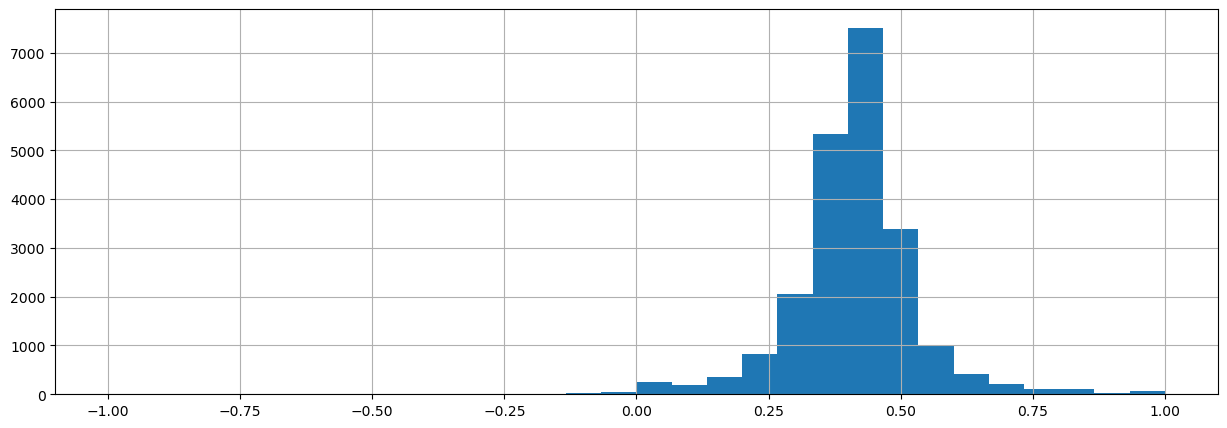

In [52]:
#check sentiment score distribution
listings_with_sentiment.avg_sentiment.hist(figsize=(15,5), bins=30);

### Add column for county to be used for linking to location specific data - NOT USED

In [ ]:
#FROM LEE
# import requests
# import json
# # Your Google Maps Geocoding API key
# API_KEY = 'YOUR_API_KEY_HERE'
# def geocode_address(address):
#     """Geocode the address using Google Maps API and return the city and state."""
#     base_url = "https://maps.googleapis.com/maps/api/geocode/json"
#     params = {
#         'address': address,
#         'key': API_KEY
#     }
#     response = requests.get(base_url, params=params)
#     if response.status_code == 200:
#         data = response.json()
#         if data['status'] == 'OK':
#             # Extract city and state from the response
#             components = data['results'][0]['address_components']
#             city = None
#             state = None
#             for component in components:
#                 if 'locality' in component['types']:
#                     city = component['long_name']
#                 elif 'administrative_area_level_1' in component['types']:
#                     state = component['long_name']
#             return city, state
#     return None, None
# # List of neighborhoods
# neighborhoods = [
#     "Seattle, Washington, United States",
#     "Ballard, Seattle, Washington, United States",
#     # ... (Add other neighborhoods)
# ]
# # Geocode each neighborhood and store the results
# geocoded_neighborhoods = {}
# for neighborhood in neighborhoods:
#     city, state = geocode_address(neighborhood)
#     geocoded_neighborhoods[neighborhood] = (city, state)
# # Output the results
# for neighborhood, (city, state) in geocoded_neighborhoods.items():
#     print(f"{neighborhood}: City: {city}, State: {state}")

### Create 'county', 'city', 'state' columns in listing df

In [69]:
#create test set to time and scale function below
test_data = listings_with_sentiment.sample(frac=0.10, random_state=42)

In [71]:
#testing with portions of df to time profile the runtime
import requests
import pandas as pd
import time

API_KEY = 'enter key here'

def get_location_info(row):
    """Geocode the lat/lon using Google Maps API and return county, city, and state."""
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    lat, lon = row['latitude'], row['longitude']
    
    params = {
        "latlng": f"{lat},{lon}",
        "key": API_KEY
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    # Initialize variables
    county = ""
    city = ""
    state = ""

    if "results" in data:
        for result in data["results"]:
            for component in result["address_components"]:
                if "administrative_area_level_2" in component["types"]:
                    county = component["long_name"]
                elif "locality" in component["types"]:
                    city = component["long_name"]
                elif "administrative_area_level_1" in component["types"]:
                    state = component["long_name"]

            if county and city and state:
                break

    return county, city, state


# Apply the function to create the 'county', 'city' and 'state' columns

start_time = time.time()

# Apply the function to create the 'county', 'city', and 'state' columns
test_data['county'], test_data['city'], test_data['state'] = zip(*test_data.apply(get_location_info, axis=1))

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 1217.2766604423523 seconds


In [75]:
import requests
import pandas as pd
import time

API_KEY = 'enter key here'

def get_location_info(row):
    """Geocode the lat/lon using Google Maps API and return county, city, and state."""
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    lat, lon = row['latitude'], row['longitude']
    
    params = {
        "latlng": f"{lat},{lon}",
        "key": API_KEY
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    # Initialize variables
    county = ""
    city = ""
    state = ""

    if "results" in data:
        for result in data["results"]:
            for component in result["address_components"]:
                if "administrative_area_level_2" in component["types"]:
                    county = component["long_name"]
                elif "locality" in component["types"]:
                    city = component["long_name"]
                elif "administrative_area_level_1" in component["types"]:
                    state = component["long_name"]

            if county and city and state:
                break

    return county, city, state


# Apply the function to create the 'county', 'city' and 'state' columns

start_time = time.time()

# Apply the function to create the 'county', 'city', and 'state' columns
listings_with_sentiment['county'], listings_with_sentiment['city'], listings_with_sentiment['state'] = zip(*listings_with_sentiment.apply(get_location_info, axis=1))
mapped_listings_with_sentiment = listings_with_sentiment.copy()
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

In [76]:
mapped_listings_with_sentiment.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'num_bathrooms', 'avg_sentiment', 'county', 'city', 'state'],
      dtype='object')

In [26]:
mapped_listings_with_sentiment.head()

,id,name,description,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,num_bathrooms,avg_sentiment,county,city,state
0,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,4.76,4.88,4.57,0,0.93,1.0,0.232675,King County,Seattle,Washington
1,9531,Home in Seattle · ★4.96 · 2 bedrooms · 3 beds ...,The Sweet Orange is a delightful and spacious ...,The neighborhood is awesome! Just far enough ...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55495,-122.38663,Entire home,...,4.96,4.97,4.91,0,0.54,1.0,0.458615,King County,Seattle,Washington
2,9534,Guest suite in Seattle · ★4.99 · 2 bedrooms · ...,Welcome to my delicious Tangerine Dream! A co...,The neighborhood is the best of two worlds...w...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.55627,-122.38607,Entire guest suite,...,4.99,4.96,4.95,0,0.53,1.0,0.415740,King County,Seattle,Washington
3,9596,Rental unit in Seattle · ★4.56 · 1 bedroom · 4...,"We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65608,-122.33602,Entire rental unit,...,4.66,4.91,4.56,0,0.65,1.0,NaN,King County,Seattle,Washington
4,9909,Home in Seattle · ★4.80 · 2 bedrooms · 2 beds ...,Our two-bedroom home is nestled in a quiet nei...,The Luna Park neighborhood is located just a f...,"Seattle, Washington, United States",Fairmount Park,West Seattle,47.56612,-122.37273,Entire home,...,4.94,4.83,4.82,1,0.49,1.0,0.353829,King County,Seattle,Washington


## **Add other datasets to mapped_listings_with_sentiment**

### Unemployment rate

In [81]:
unemployment = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/unemployment%20by%20county.csv?token=GHSAT0AAAAAACJYALPLAK5XO4QQFMF4R2CQZLXE3BQ')
unemployment.head()

,Year,Month,State,County,Rate
0,2015,February,Mississippi,Newton County,6.1
1,2015,February,Mississippi,Panola County,9.4
2,2015,February,Mississippi,Monroe County,7.9
3,2015,February,Mississippi,Hinds County,6.1
4,2015,February,Mississippi,Kemper County,10.6


In [82]:
unemployment.dtypes

Year        int64
Month      object
State      object
County     object
Rate      float64
dtype: object

In [93]:
# Filter 'unemployment' DataFrame for Year == 2015
unemployment_2015 = unemployment[unemployment['Year'] == 2015]

# Calculate average unemployment rate per state and county for the year 2015
avg_unemployment_rate = unemployment_2015.groupby(['State', 'County'])['Rate'].mean().reset_index()

# Merge 'mapped_listings_with_sentiment' with average unemployment rates
mapped_listings_with_sentiment = pd.merge(
    mapped_listings_with_sentiment,
    avg_unemployment_rate,
    how='left',
    left_on=['state', 'county'],
    right_on=['State', 'County']
)

# Rename the column and fill NaN values with a default unemployment rate
mapped_listings_with_sentiment.rename(columns={'Rate': 'unemployment_rate'}, inplace=True)
#mapped_listings_with_sentiment['unemployment_rate'].fillna(default_rate, inplace=True)  # Replace default_rate with your default value

In [95]:
columns_to_drop = ['State', 'County']
mapped_listings_with_sentiment.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
mapped_listings_with_sentiment.head()

In [97]:
#save as we add columns from location dfs
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

### State crime rates

In [87]:
state_crime = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/dfs_for_master/crimes_by_state.csv?token=GHSAT0AAAAAACJYALPLZM6FRF67RHWMGXVQZLZ2PCQ')
state_crime.head()

,year,state_abbr,state_name,population,violent_crime,homicide,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny,motor_vehicle_theft,caveats
0,1979,NaN,NaN,220099000,1208030,21460,76390.0,480700,629480,11041500,3327700,6601000,1112800,NaN
1,1979,AK,Alaska,406000,1994,54,292.0,445,1203,23193,5616,15076,2501,NaN
2,1979,AL,Alabama,3769000,15578,496,1037.0,4127,9918,144372,48517,83791,12064,NaN
3,1979,AR,Arkansas,2180000,7984,198,595.0,1626,5565,70949,21457,45267,4225,NaN
4,1979,AZ,Arizona,2450000,14528,219,1120.0,4305,8884,177977,48916,116976,12085,NaN


In [ ]:
state_crime.dtypes

In [99]:
# Filter 'state_crime' DataFrame for Year == 2019
state_crime_2019 = state_crime[state_crime['year'] == 2019]

# Merge 'mapped_listings_with_sentiment' with crime rates
columns_to_merge = ['state_name','population', 'violent_crime', 'homicide', 'rape_legacy', 'robbery', 'aggravated_assault', 'property_crime', 'burglary', 'larceny', 'motor_vehicle_theft']

mapped_listings_with_sentiment = pd.merge(
    mapped_listings_with_sentiment,
    state_crime_2019[columns_to_merge],
    how='left',
    left_on='state',
    right_on='state_name'
)
mapped_listings_with_sentiment.drop('state_name', axis=1, inplace=True)


In [ ]:
mapped_listings_with_sentiment.head()

In [103]:
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

### County gun deaths

In [6]:
county_gun_deaths = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/dfs_for_master/gun_deaths_us_1999_2019.csv?token=GHSAT0AAAAAACJYALPKUUMRVP6DDA6X4WI2ZLZ2OYQ')
county_gun_deaths.head()

,Unnamed: 0,Year,County,County Code,State,State_Name,State Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval
0,0,1999,Baldwin County,1003,AL,Alabama,1,22,137555,15.99,10.02,24.21,16.28,10.20,24.64
1,1,1999,Calhoun County,1015,AL,Alabama,1,29,114910,25.24,16.90,36.24,25.21,16.89,36.21
2,2,1999,Chambers County,1017,AL,Alabama,1,10,36527,NaN,13.13,50.35,NaN,12.91,49.51
3,3,1999,Colbert County,1033,AL,Alabama,1,14,54715,NaN,13.99,42.93,NaN,13.54,41.57
4,4,1999,Dallas County,1047,AL,Alabama,1,11,46722,NaN,11.75,42.13,NaN,12.15,43.54


In [ ]:
county_gun_deaths.dtypes

In [106]:
# Filter 'county_gun_deaths' DataFrame for Year == 2015-2019
county_gun_deaths_recent = county_gun_deaths[(county_gun_deaths['Year'] >= 2015)]

# Merge 'mapped_listings_with_sentiment' with crime rates
mapped_listings_with_sentiment = pd.merge(
    mapped_listings_with_sentiment,
    county_gun_deaths_recent[['State_Name', 'County', 'Crude Rate']],  # Selecting only required columns
    how='left',
    left_on=['state', 'county'],
    right_on=['State_Name', 'County']
)

# Drop the extra columns created for matching
mapped_listings_with_sentiment.drop(columns=['State_Name', 'County'], inplace=True)


In [108]:
mapped_listings_with_sentiment.rename(columns={'Crude Rate': 'gun_death_per_100k'}, inplace=True)

In [ ]:
mapped_listings_with_sentiment.head()

In [110]:
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

### State cost of living index

In [7]:
city_cost_of_living = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/dfs_for_master/advisorsmith_cost_of_living_index.csv?token=GHSAT0AAAAAACJYALPL5QVVYE4R6INRRPI2ZLZ2QAQ')
city_cost_of_living.head()

,City,State,Cost of Living Index
0,Abilene,TX,89.1
1,Adrian,MI,90.5
2,Akron,OH,89.4
3,Alamogordo,NM,85.8
4,Albany,GA,87.3


In [112]:
city_cost_of_living.dtypes

City                     object
State                    object
Cost of Living Index    float64
dtype: object

In [120]:
state_abbr_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'Puerto Rico': 'PR'
}

# Create the new 'State_Long' column in city_cost_of_living using the mapping dictionary
state_abbr_mapping_inv = {v: k for k, v in state_abbr_mapping.items()}
city_cost_of_living['State_Long'] = city_cost_of_living['State'].map(state_abbr_mapping_inv)

# Merge 'mapped_listings_with_sentiment' with city cost of living based on the new column 'State_Long'
mapped_listings_with_sentiment = pd.merge(
    mapped_listings_with_sentiment,
    city_cost_of_living,
    how='left',
    left_on=['state', 'city'],
    right_on=['State_Long', 'City']
)
#drop extra columns
mapped_listings_with_sentiment.drop(columns=['State_Long','State', 'City'], inplace=True)

In [ ]:
mapped_listings_with_sentiment.head()

In [123]:
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

### County census data

In [8]:
census_demographics = pd.read_csv('https://raw.githubusercontent.com/kflemming30/Urban_Dynamics_and_Airbnb_Reviews/main/dfs_for_master/census_county_data.csv?token=GHSAT0AAAAAACJYALPKGHQ3VAKXBHJOM23QZLZ2QVA')
census_demographics.head()

,CountyId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [ ]:
census_demographics.dtypes

In [125]:
# Merge 'mapped_listings_with_sentiment' with crime rates
mapped_listings_with_sentiment = pd.merge(
    mapped_listings_with_sentiment,
    census_demographics,  
    how='left',
    left_on=['state', 'county'],
    right_on=['State', 'County']
)
#drop extra columns
mapped_listings_with_sentiment.drop(columns=['State', 'County'], inplace=True)

In [ ]:
mapped_listings_with_sentiment.head()

In [127]:
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

### City, State Average Temps

In [11]:
#from local because file is so large
file_path = r"C:\Users\12039\Documents\6505-Project\dfs_for_master\city_temperature.csv"

# Read the CSV file into a DataFrame
avg_temps = pd.read_csv(file_path)
avg_temps.head()

C:\Users\12039\AppData\Local\Temp\ipykernel_37340\3645691722.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  avg_temps = pd.read_csv(file_path)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [12]:
avg_temps_us = avg_temps[(avg_temps['Country'] == 'US') & (avg_temps['Year'] == 2020)]

In [13]:
avg_temp_by_city_state = avg_temps_us.groupby(['State', 'City'])['AvgTemperature'].mean().reset_index()
avg_temp_by_city_state.rename(columns={'AvgTemperature': 'avg_temp'}, inplace=True)

In [14]:
avg_temp_by_city_state.head()

,State,City,avg_temp
0,Alabama,Birmingham,57.031343
1,Alabama,Huntsville,53.564179
2,Alabama,Mobile,61.558955
3,Alabama,Montgomery,60.309701
4,Alaska,Anchorage,24.004478


In [15]:
mapped_listings_with_sentiment = pd.merge(
    mapped_listings_with_sentiment,
    avg_temp_by_city_state[['State', 'City', 'avg_temp']],
    how='left',
    left_on=['state', 'city'],
    right_on=['State', 'City']
)

mapped_listings_with_sentiment.drop(['State', 'City'], axis=1, inplace=True)

In [ ]:
mapped_listings_with_sentiment.head()

In [139]:
mapped_listings_with_sentiment.to_csv('mapped_listings_with_sentiment.csv', index=False)

## **Clean mapped_listings_with_sentiment to create analysis_df**

In [137]:
null_percentage = (mapped_listings_with_sentiment.isna().mean() * 100).round(2).sort_values(ascending=False)
print(null_percentage)

rape_legacy                    100.00
avg_temp                        61.37
Cost of Living Index            26.27
avg_sentiment                   19.55
gun_death_per_100k               3.20
                                ...  
instant_bookable                 0.00
review_scores_value              0.00
review_scores_location           0.00
review_scores_communication      0.00
burglary                         0.00
Length: 81, dtype: float64


In [140]:
def drop_na_columns(df, threshold=0.5):
    # Calculate the threshold count
    threshold_count = len(df) * threshold
    # Drop columns where the count of NA values exceeds the threshold
    df = df.dropna(axis=1, thresh=threshold_count)
    return df

# Applying the drop_na_columns function to mapped_listings_with_sentiment
analysis_df = drop_na_columns(mapped_listings_with_sentiment)

In [ ]:
# Applying the drop_na_columns function to mapped_listings_with_sentiment
analysis_df = drop_na_columns(mapped_listings_with_sentiment)

In [157]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136419 entries, 0 to 136418
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            136419 non-null  int64  
 1   name                          136419 non-null  object 
 2   description                   136419 non-null  object 
 3   neighborhood_overview         136419 non-null  object 
 4   neighbourhood                 136419 non-null  object 
 5   neighbourhood_cleansed        136419 non-null  object 
 6   neighbourhood_group_cleansed  136419 non-null  object 
 7   latitude                      136419 non-null  float64
 8   longitude                     136419 non-null  float64
 9   property_type                 136419 non-null  object 
 10  room_type                     136419 non-null  object 
 11  accommodates                  136419 non-null  int64  
 12  bedrooms                      136419 non-nul

In [ ]:
analysis_df.columns

In [144]:
#confrim removal of all null values
analysis_df.isna().any()

id                       False
name                     False
description              False
neighborhood_overview    False
neighbourhood            False
                         ...  
PrivateWork               True
PublicWork                True
SelfEmployed              True
FamilyWork                True
Unemployment              True
Length: 79, dtype: bool

In [146]:
analysis_df.head()

,id,name,description,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,5.1,2.7,6.5,29.1,1140353.0,82.0,12.0,5.8,0.2,5.0
1,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,5.1,2.7,6.5,29.1,1140353.0,82.0,12.0,5.8,0.2,5.0
2,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,5.1,2.7,6.5,29.1,1140353.0,82.0,12.0,5.8,0.2,5.0
3,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,5.1,2.7,6.5,29.1,1140353.0,82.0,12.0,5.8,0.2,5.0
4,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,5.1,2.7,6.5,29.1,1140353.0,82.0,12.0,5.8,0.2,5.0


In [148]:
analysis_df.loc[:,'homicide_per_100k'] = (analysis_df['homicide'] / analysis_df['population']) * 100000
analysis_df.loc[:,'robbery_per_100k'] = (analysis_df['robbery'] / analysis_df['population']) * 100000
analysis_df.loc[:,'property_crime_per_100k'] = (analysis_df['property_crime'] / analysis_df['population']) * 100000
analysis_df.loc[:,'burglary_per_100k'] = (analysis_df['burglary'] / analysis_df['population']) * 100000

In [149]:
#remove columns
columns_to_drop = ['population', 'violent_crime', 'homicide', 'robbery', 'aggravated_assault',
                   'property_crime', 'burglary', 'larceny', 'motor_vehicle_theft', 'CountyId']

analysis_df.drop(columns=columns_to_drop, inplace=True)

In [152]:
analysis_df.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'num_bathrooms', 'avg_sentiment', 'county', 'city', 'state',
       'unemployment_rate', 'gun_death_per_100k', 'Cost of Living Index',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       '

In [153]:
#remove columns
columns_to_drop = ['VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication',]

analysis_df.drop(columns=columns_to_drop, inplace=True)

In [159]:
analysis_df.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_location', 'review_scores_value',
       'instant_bookable', 'reviews_per_month', 'num_bathrooms',
       'avg_sentiment', 'county', 'city', 'state', 'unemployment_rate',
       'gun_death_per_100k', 'Cost of Living Index', 'TotalPop', 'Men',
       'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'Unemployment', 'homicide_per_100k', 'robbery_per_100k',
       'property_crime_per_100k', 'burglary_per_100k'],
      dtype='object')

In [160]:
analysis_df.to_csv('analysis_df.csv', index=False)

In [53]:
file_path = r"C:\Users\12039\Documents\6505-Project\analysis_df.csv"

# Read the CSV file into a DataFrame
new_analysis_df = pd.read_csv(file_path)

In [54]:
new_analysis_df.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'price', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_location', 'review_scores_value',
       'instant_bookable', 'reviews_per_month', 'num_bathrooms',
       'avg_sentiment', 'county', 'city', 'state', 'unemployment_rate',
       'gun_death_per_100k', 'Cost of Living Index', 'TotalPop', 'Men',
       'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',
       'Unemployment', 'homicide_per_100k', 'robbery_per_100k',
       'property_crime_per_100k', 'burglary_per_100k'],
      dtype='object')

In [56]:
new_analysis_df['state'].unique()

array(['Washington', 'California', 'NC', 'TN', 'New York', 'AL', 'TX'],
      dtype=object)

In [57]:
# Filter rows where 'state' is 'Washington', 'California', or 'New York'
new_analysis_df = new_analysis_df[new_analysis_df['state'].isin(['Washington', 'California', 'New York'])]


In [58]:
new_analysis_df['state'].unique()

array(['Washington', 'California', 'New York'], dtype=object)

In [59]:
new_analysis_df.to_csv('new_analysis_df.csv', index=False)

---
# **EXPLORATORY ANALYSIS**

### **Run these cells to download large file to do analysis**

In [8]:
!pip install --trusted-host pypi.python.org --trusted-host pypi.org --trusted-host files.pythonhosted.org gdown

# to upgrade
!pip install --upgrade gdown

Could not fetch URL https://pypi.org/simple/gdown/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/gdown/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1131)'))) - skipping


In [11]:
import gdown

file_id = '1ZT_oSrwnriFSScdmFVR5yy2oRYF9kBJ0'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'analysis_df.csv'

# Download with SSL check disabled
gdown.download(url, output, quiet=False, use_cookies=False, verify=False)



C:\Users\gdougherty\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\gdougherty\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\gdougherty\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doc-0c-9s-docs.googleusercontent.com'. Adding certificate verification is strongly advised. See: 

'analysis_df.csv'

In [12]:
import pandas as pd
# Assuming the file name is 'your_downloaded_file.csv'
file_path = 'analysis_df.csv'

# Load the CSV file into a Pandas DataFrame
analysis_df = pd.read_csv(file_path)

# Now you can work with 'df', which contains the data from your CSV file
# For example, you can print the first few rows:
analysis_df.head()

,id,name,description,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,...,White,Black,Native,Asian,Pacific,Unemployment,homicide_per_100k,robbery_per_100k,property_crime_per_100k,burglary_per_100k
0,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,61.4,6.0,0.5,16.5,0.8,5.0,2.600168,67.591232,2681.902425,453.584837
1,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,61.4,6.0,0.5,16.5,0.8,5.0,2.600168,67.591232,2681.902425,453.584837
2,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,61.4,6.0,0.5,16.5,0.8,5.0,2.600168,67.591232,2681.902425,453.584837
3,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,61.4,6.0,0.5,16.5,0.8,5.0,2.600168,67.591232,2681.902425,453.584837
4,6606,Guesthouse in Seattle · ★4.60 · 1 bedroom · 1 ...,"This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...","Seattle, Washington, United States",Wallingford,Other neighborhoods,47.65444,-122.33629,Entire guesthouse,...,61.4,6.0,0.5,16.5,0.8,5.0,2.600168,67.591232,2681.902425,453.584837


## **Listings and Ratings**

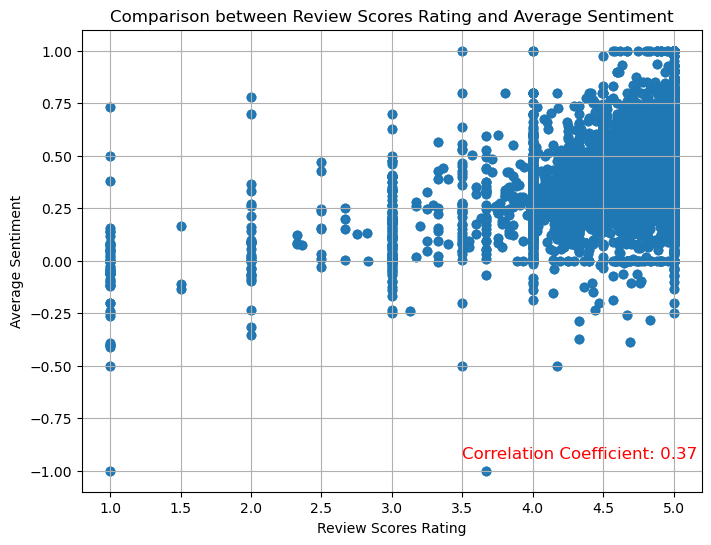

In [30]:
# Scatter plot to compare 'review_scores_rating' and 'avg_sentiment'
selected_cities = ['Seattle','New York','Los Angeles']
# Calculate the correlation coefficient
correlation_coefficient = analysis_df['review_scores_rating'].corr(analysis_df['avg_sentiment'])

plt.figure(figsize=(8, 6))
plt.scatter(analysis_df['review_scores_rating'], analysis_df['avg_sentiment'], alpha=0.5)
plt.xlabel('Review Scores Rating')
plt.ylabel('Average Sentiment')
plt.title('Comparison between Review Scores Rating and Average Sentiment')
plt.grid(True)
# Add the correlation coefficient to the plot as an annotation
# Add the correlation coefficient to the plot as an annotation
plt.annotate(f'Correlation Coefficient: {correlation_coefficient:.2f}', 
             xy=(analysis_df['review_scores_rating'].max() - 1.5 , 
                 analysis_df['avg_sentiment'].min() + 0.06),
             fontsize=12, color='red')
plt.show()

In [31]:

all_correlation = analysis_df['unemployment_rate'].corr(analysis_df['review_scores_rating'])

print(f'Correlation between unemployment_rate and review_scores_rating: {all_correlation}')


Correlation between unemployment_rate and review_scores_rating: 0.033559690733542716


The correlation coefficient of 0.0335596907335427 between the unemployment rate and review_scores_rating suggests a very weak positive correlation between these two variables. 

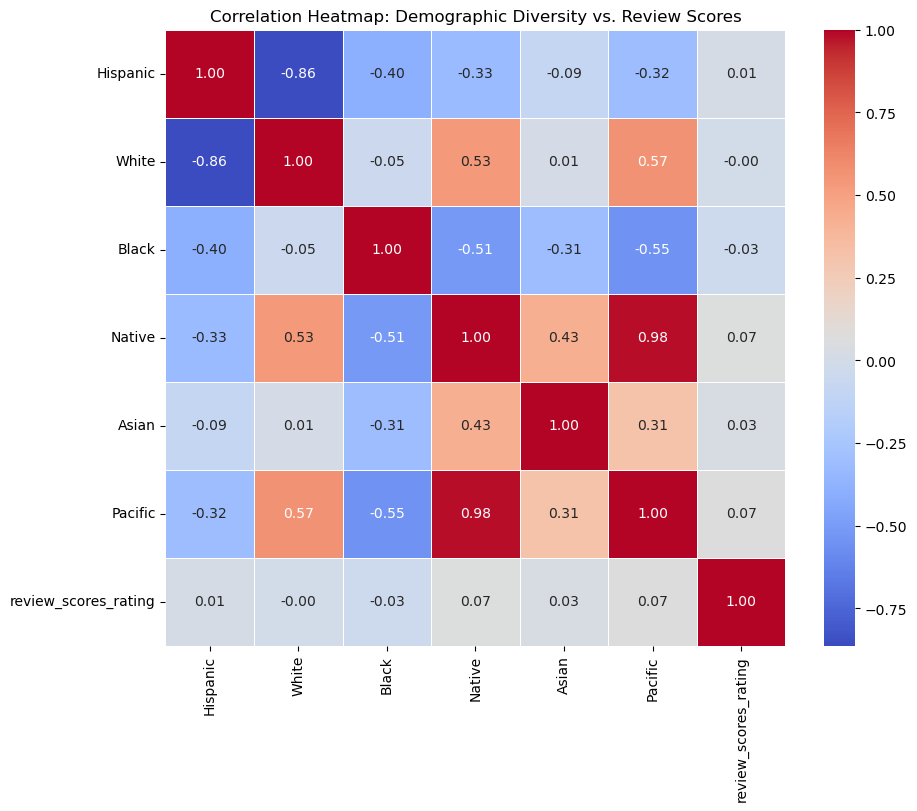

In [32]:

demographic_columns = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'review_scores_rating']

# Drop rows with missing values in the selected columns
demographic_data = analysis_df[demographic_columns].dropna()

# Calculate correlation matrix
correlation_matrix = demographic_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set the title and display the plot
plt.title('Correlation Heatmap: Demographic Diversity vs. Review Scores')
plt.show()


In summary, while there are some correlations observed, they are generally weak to moderate

In [33]:
from scipy.stats import pearsonr
demographic_columns = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'review_scores_rating']

correlation, p_value = pearsonr(demographic_data['Hispanic'], demographic_data['review_scores_rating'])

print(f'Correlation: {correlation:.2f}')
print(f'P-value: {p_value:.4f}')

# Set the significance level
alpha = 0.05

# Check if the p-value is below the significance level
if p_value > alpha:
    print('The correlation is statistically significant.')
else:
    print('The correlation is not statistically significant.')


Correlation: 0.01
P-value: 0.0000
The correlation is not statistically significant.


C:\Users\gdougherty\AppData\Local\Temp\ipykernel_58472\992380806.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='review_scores_rating', data=state_reviews, palette='viridis')


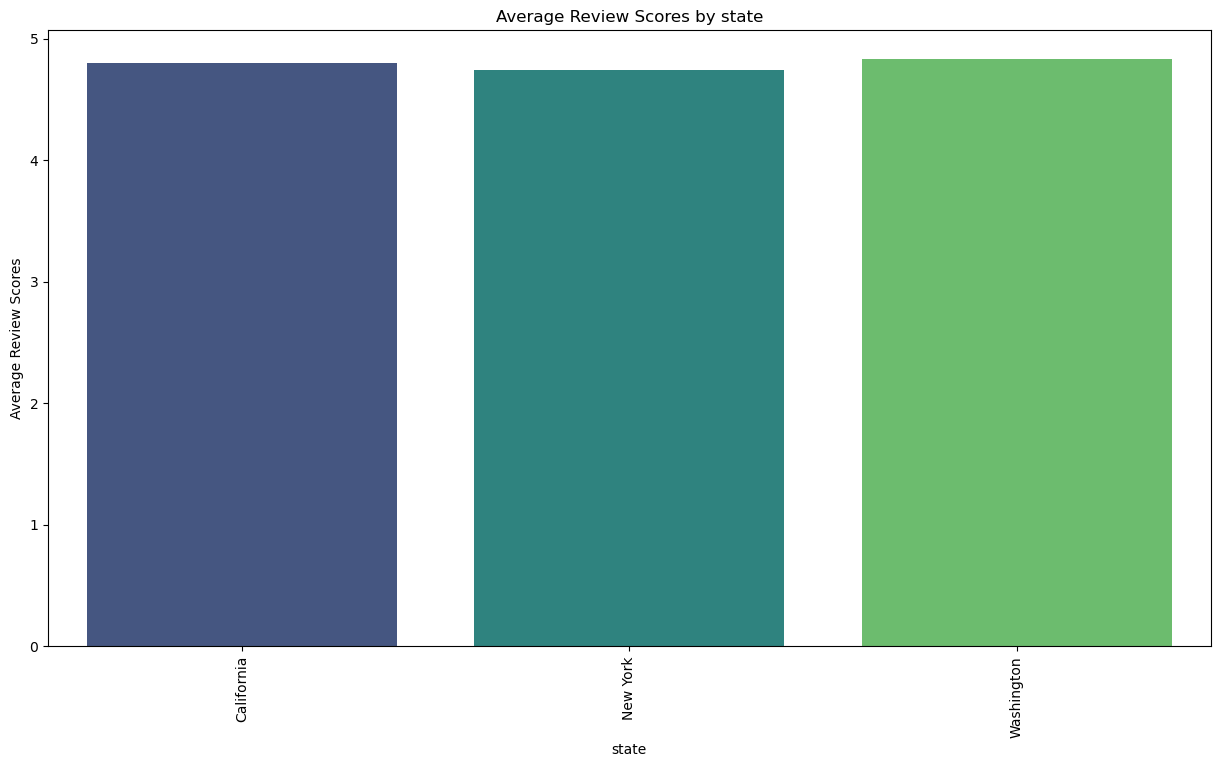

In [34]:

plt.figure(figsize=(15, 8))

# Group by 'neighbourhood' and calculate the mean review scores
state_reviews = analysis_df.groupby('state')['review_scores_rating'].mean().reset_index()

# Create a bar chart
sns.barplot(x='state', y='review_scores_rating', data=state_reviews, palette='viridis')
plt.title('Average Review Scores by state')
plt.xlabel('state')
plt.ylabel('Average Review Scores')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()


C:\Users\gdougherty\AppData\Local\Temp\ipykernel_58472\2169210787.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='city', y='avg_sentiment', data=city_reviews, palette='viridis')


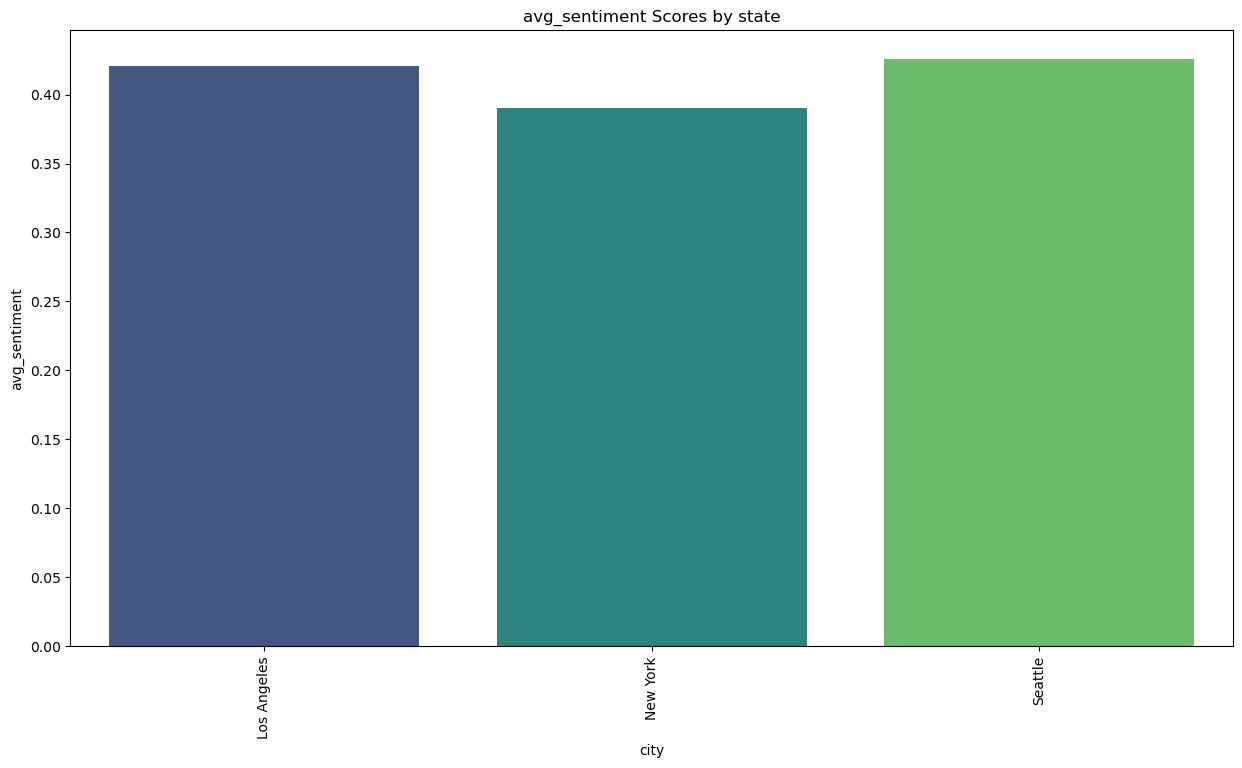

In [35]:
# Assuming 'cleaned_all_listings' is your DataFrame
plt.figure(figsize=(15, 8))

# Group by 'neighbourhood' and calculate the mean review scores
selected_cities = ['Seattle','New York','Los Angeles']
city_reviews = analysis_df[analysis_df['city'].isin(selected_cities)]
city_reviews = city_reviews.groupby('city')['avg_sentiment'].mean().reset_index()

# Create a bar chart
sns.barplot(x='city', y='avg_sentiment', data=city_reviews, palette='viridis')
plt.title('avg_sentiment Scores by state')
plt.xlabel('city')
plt.ylabel('avg_sentiment')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()


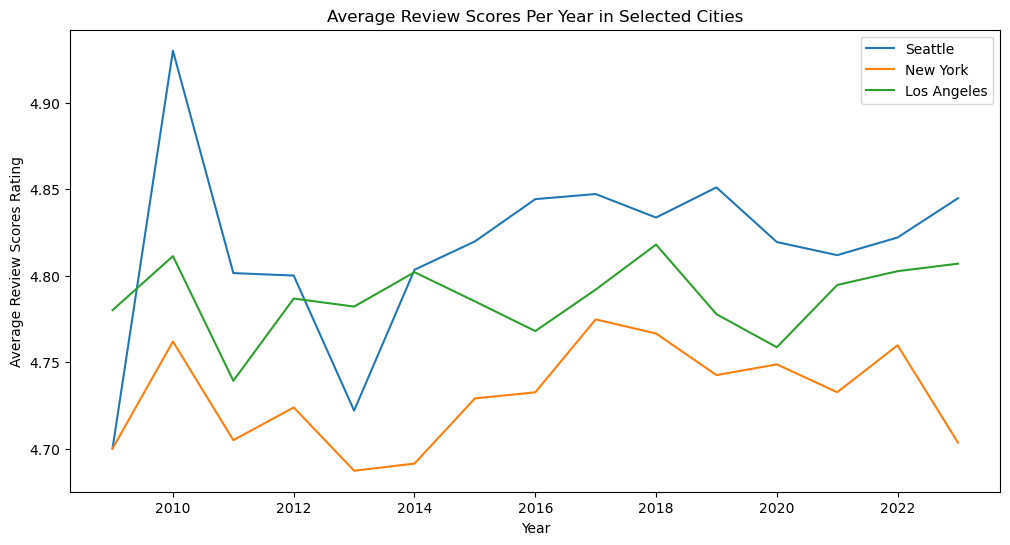

In [36]:

# Convert 'first_review' to datetime if it's not already
analysis_df['first_review'] = pd.to_datetime(analysis_df['first_review'])

# Extract the year from the 'first_review' column
analysis_df['review_year'] = analysis_df['first_review'].dt.year

plt.figure(figsize=(12, 6))

for city in selected_cities:
    city_data = analysis_df[analysis_df['city'] == city]
    avg_review_per_year = city_data.groupby('review_year')['review_scores_rating'].mean()
    plt.plot(avg_review_per_year.index, avg_review_per_year, label=city)

plt.title('Average Review Scores Per Year in Selected Cities')
plt.xlabel('Year')
plt.ylabel('Average Review Scores Rating')
plt.legend()
plt.show()


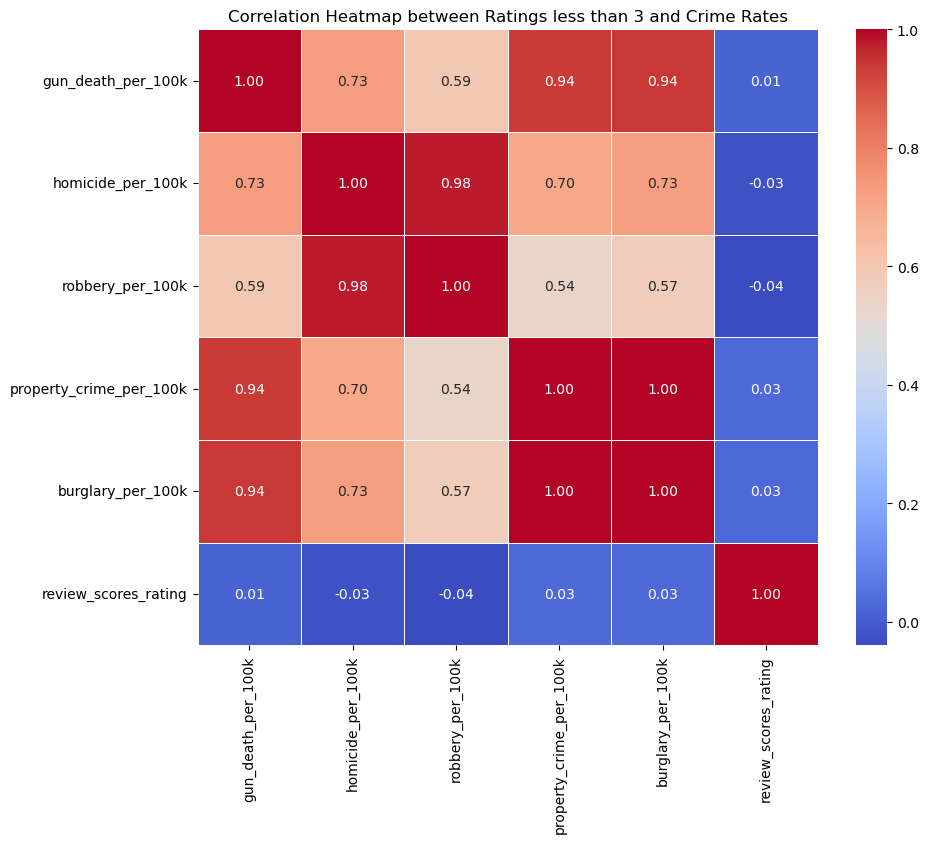

In [37]:
analysis_df_selected_cities = analysis_df[analysis_df['city'].isin(selected_cities)]

# Crime-related columns
crime_columns = ['gun_death_per_100k', 'homicide_per_100k', 'robbery_per_100k', 'property_crime_per_100k', 'burglary_per_100k']

# Define a threshold for low ratings (e.g., ratings less than 3)
low_rating_threshold = 3
low_ratings = analysis_df_selected_cities[analysis_df_selected_cities['review_scores_rating'] < low_rating_threshold]

# Calculate the correlation matrix between low ratings and crime rates
correlation_matrix_low_ratings = low_ratings[crime_columns + ['review_scores_rating']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_low_ratings, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap between Ratings less than 3 and Crime Rates')
plt.show()


Although there is a correlation between the different crime rates, these crime rates do not have a high correlation to review score ratings

In [38]:

selected_columns = [
    'accommodates', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'reviews_per_month',
    'num_bathrooms','TotalPop', 'avg_sentiment', 'unemployment_rate', 'review_scores_rating','Cost of Living Index','instant_bookable'
]


correlation_data = analysis_df[selected_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()


# Extract correlations with 'review_scores_rating'
review_rating_correlations = correlation_matrix['review_scores_rating']

# Display correlations sorted by magnitude
sorted_correlations = review_rating_correlations.abs().sort_values(ascending=False)
print(sorted_correlations)


review_scores_rating    1.000000
avg_sentiment           0.369120
reviews_per_month       0.096653
number_of_reviews       0.067536
instant_bookable        0.055429
TotalPop                0.052138
num_bathrooms           0.045755
bedrooms                0.035212
unemployment_rate       0.033560
beds                    0.025657
accommodates            0.025112
Cost of Living Index    0.022610
price                   0.021966
Name: review_scores_rating, dtype: float64


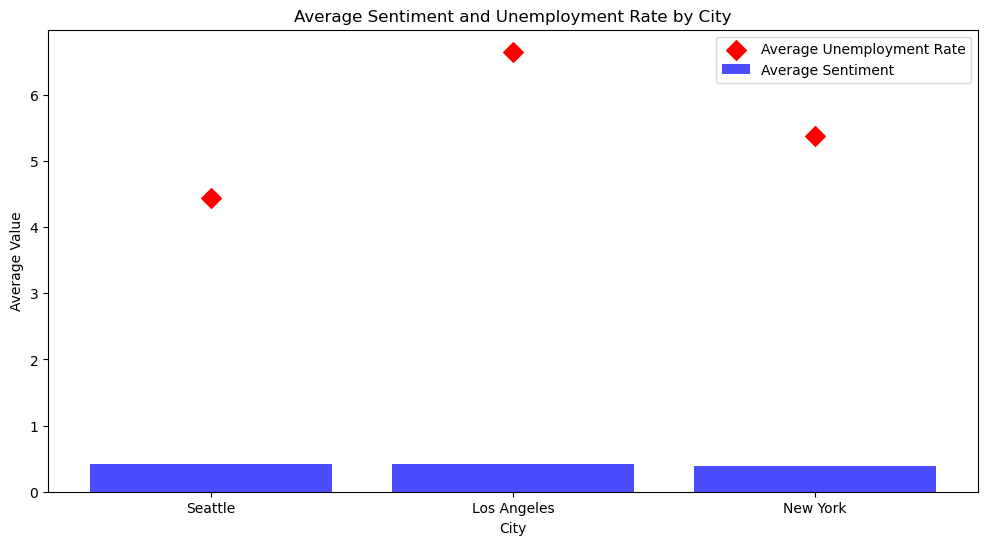

In [39]:


# Economic and sentiment columns
economic_columns = ['unemployment_rate']
sentiment_columns = ['avg_sentiment']

# Calculate average unemployment rate and average sentiment for each city
avg_unemployment_by_city = analysis_df_selected_cities.groupby('city')['unemployment_rate'].mean().sort_values(ascending=False)
avg_sentiment_by_city = analysis_df_selected_cities.groupby('city')['avg_sentiment'].mean().sort_values(ascending=False)

# Plot bar chart for average sentiment
plt.figure(figsize=(12, 6))
plt.bar(avg_sentiment_by_city.index, avg_sentiment_by_city, color='blue', alpha=0.7, label='Average Sentiment')

# Plot point for average unemployment rate
plt.scatter(avg_unemployment_by_city.index, avg_unemployment_by_city, color='red', marker='D', s=100, label='Average Unemployment Rate')

plt.title('Average Sentiment and Unemployment Rate by City')
plt.xlabel('City')
plt.ylabel('Average Value')
plt.legend()
plt.show()


# **Seattle**


C:\Users\gdougherty\AppData\Local\Temp\ipykernel_58472\3508208795.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_review_rating_by_property_type.index, y=avg_review_rating_by_property_type.values, palette='viridis')


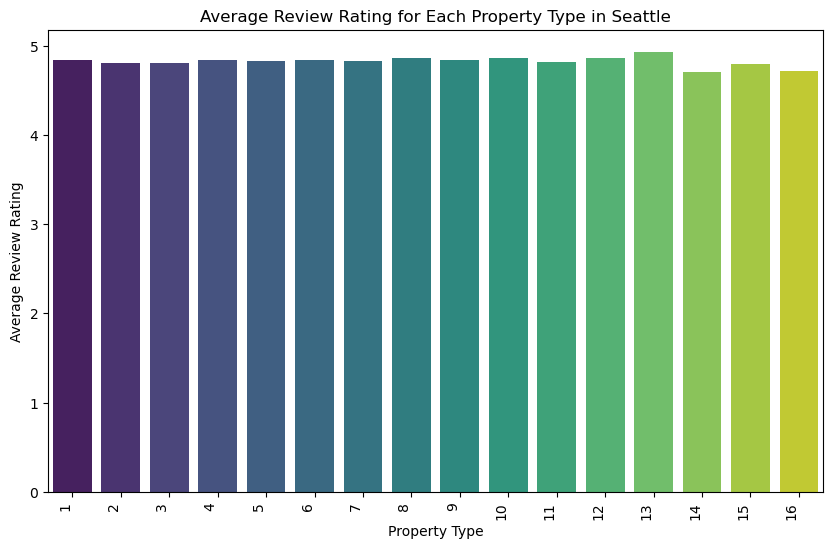

In [40]:
Seattle_Data = analysis_df_selected_cities[analysis_df_selected_cities['city'] == 'Seattle']


review_rating_columns = ['review_scores_rating']


avg_review_rating_by_property_type = Seattle_Data.groupby('accommodates')['review_scores_rating'].mean().sort_values(ascending=False)

# Plot a bar chart for the average review rating of each property type
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_review_rating_by_property_type.index, y=avg_review_rating_by_property_type.values, palette='viridis')

plt.title('Average Review Rating for Each Property Type in Seattle')
plt.xlabel('Property Type')
plt.ylabel('Average Review Rating')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.show()

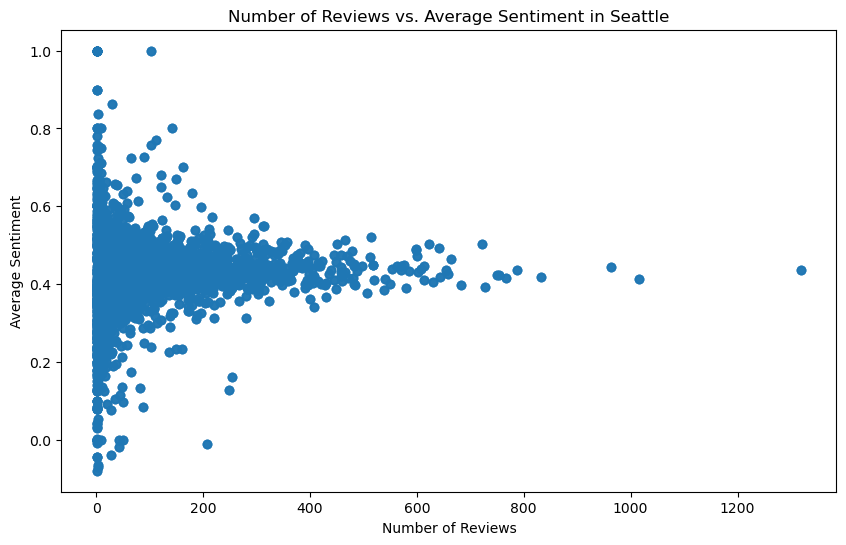

In [41]:
reviews_columns = ['number_of_reviews']
# Plot a scatter plot for the number of reviews vs. average sentiment 
plt.figure(figsize=(10, 6))
plt.scatter(Seattle_Data['number_of_reviews'], Seattle_Data['avg_sentiment'], alpha=0.5)

plt.title('Number of Reviews vs. Average Sentiment in Seattle')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Sentiment')
plt.show()

In [42]:

correlation = Seattle_Data['unemployment_rate'].corr(Seattle_Data['review_scores_rating'])

print(f'Correlation between unemployment_rate and review_scores_rating: {correlation}')


Correlation between unemployment_rate and review_scores_rating: -3.571632074963761e-15


The correlation coefficient between "unemployment_rate" and "review_scores_rating" is approximately -3.57e-15. This value is extremely close to zero, indicating a very weak or negligible correlation between these two variables.

# **LA**


C:\Users\gdougherty\AppData\Local\Temp\ipykernel_58472\2271017672.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_review_rating_by_property_type_oak.index, y=avg_review_rating_by_property_type_oak.values, palette='viridis')


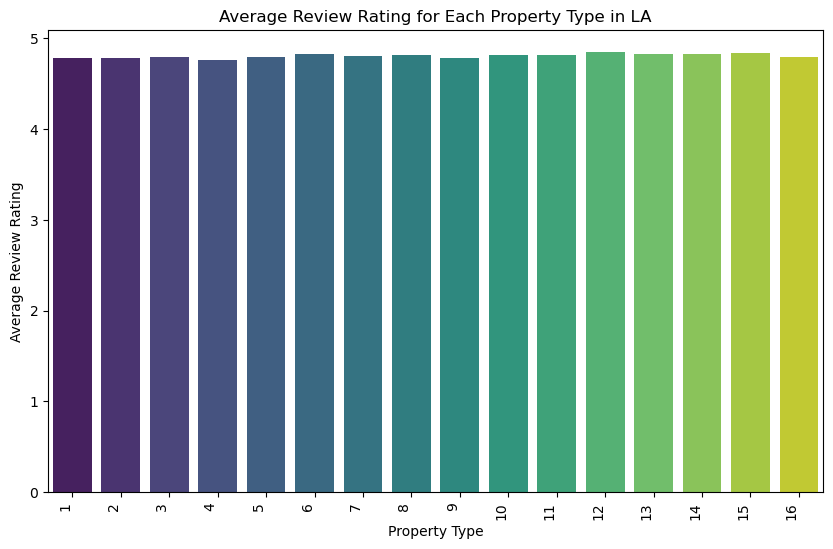

In [44]:
LA_Data = analysis_df_selected_cities[analysis_df_selected_cities['city'] == 'Los Angeles']


review_rating_columns = ['review_scores_rating']

# Calculate average review rating for each property type 
avg_review_rating_by_property_type_oak = LA_Data.groupby('accommodates')['review_scores_rating'].mean().sort_values(ascending=False)

# Plot a bar chart for the average review rating of each property type 
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_review_rating_by_property_type_oak.index, y=avg_review_rating_by_property_type_oak.values, palette='viridis')

plt.title('Average Review Rating for Each Property Type in LA')
plt.xlabel('Property Type')
plt.ylabel('Average Review Rating')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.show()

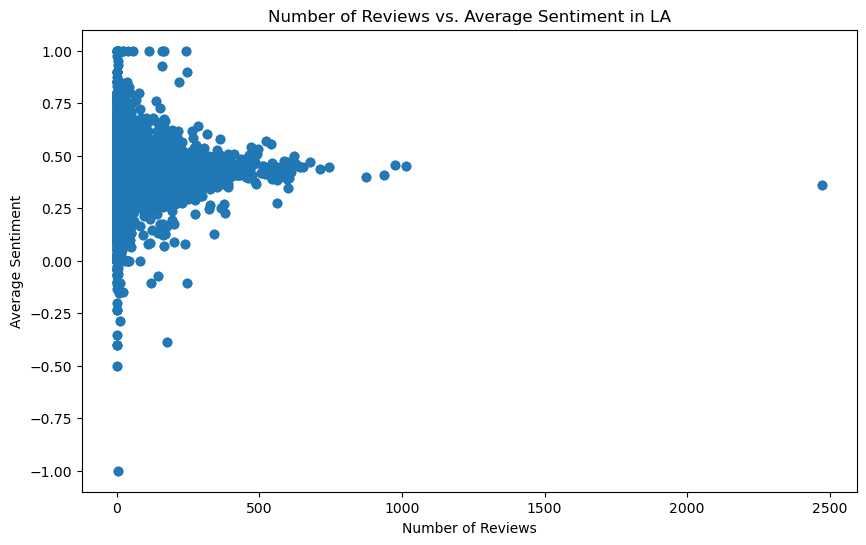

In [45]:
reviews_columns = ['number_of_reviews']
# Plot a scatter plot for the number of reviews vs. average sentiment in City_A
plt.figure(figsize=(10, 6))
plt.scatter(LA_Data['number_of_reviews'], LA_Data['avg_sentiment'], alpha=0.5)

plt.title('Number of Reviews vs. Average Sentiment in LA')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Sentiment')
plt.show()

In [47]:
# Assuming you have 'unemployment_rate' and 'review_scores_rating' columns in your DataFrame
correlation_LA = LA_Data['unemployment_rate'].corr(LA_Data['review_scores_rating'])

print(f'Correlation between unemployment_rate and review_scores_rating: {correlation_LA}')


Correlation between unemployment_rate and review_scores_rating: -8.317443005154997e-16



The correlation coefficient between "unemployment_rate" and "review_scores_rating" is approximately -8.32e-16. This value is extremely close to zero, indicating an almost negligible correlation between these two variables.

# **New York**


C:\Users\gdougherty\AppData\Local\Temp\ipykernel_58472\2011199560.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_review_rating_by_property_type_new.index, y=avg_review_rating_by_property_type_new.values, palette='viridis')


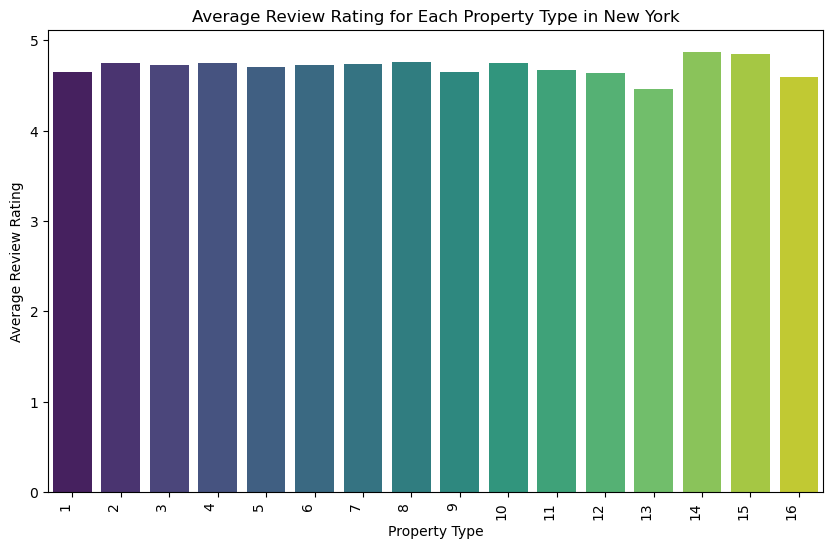

In [48]:
New_York_Data = analysis_df_selected_cities[analysis_df_selected_cities['city'] == 'New York']

# Assuming you have a 'review_scores_rating' column in your DataFrame
review_rating_columns = ['review_scores_rating']

# Calculate average review rating for each property type in City_A
avg_review_rating_by_property_type_new = New_York_Data.groupby('accommodates')['review_scores_rating'].mean().sort_values(ascending=False)

# Plot a bar chart for the average review rating of each property type in City_A
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_review_rating_by_property_type_new.index, y=avg_review_rating_by_property_type_new.values, palette='viridis')

plt.title('Average Review Rating for Each Property Type in New York')
plt.xlabel('Property Type')
plt.ylabel('Average Review Rating')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.show()

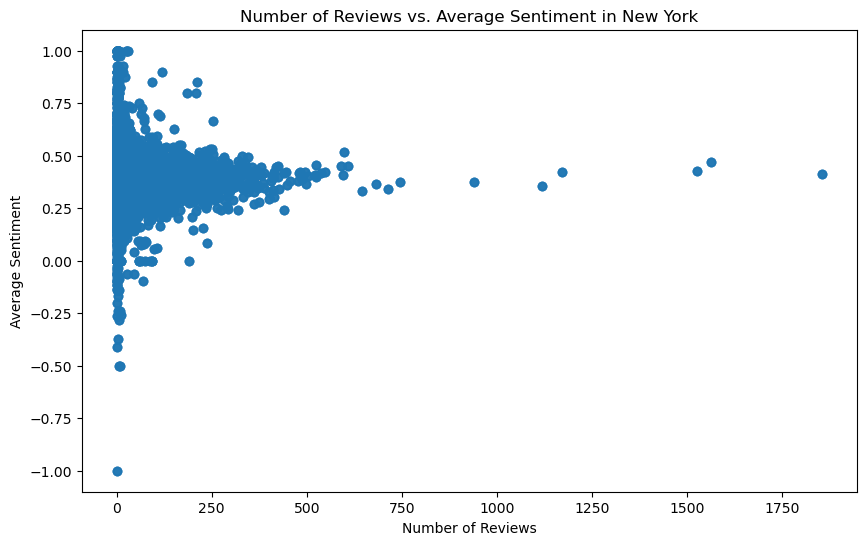

In [49]:
reviews_columns = ['number_of_reviews']
# Plot a scatter plot for the number of reviews vs. average sentiment 
plt.figure(figsize=(10, 6))
plt.scatter(New_York_Data['number_of_reviews'], New_York_Data['avg_sentiment'], alpha=0.5)

plt.title('Number of Reviews vs. Average Sentiment in New York')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Sentiment')
plt.show()

In [50]:

correlation_new = New_York_Data['unemployment_rate'].corr(New_York_Data['review_scores_rating'])

print(f'Correlation between unemployment_rate and review_scores_rating: {correlation_new}')


Correlation between unemployment_rate and review_scores_rating: 0.054608135045233576


The correlation coefficient between "unemployment_rate" and "review_scores_rating" is approximately 0.0546. This positive value indicates a very weak positive correlation between the two variables. In other words, as the "unemployment_rate" increases or decreases, there is a slight tendency for "review_scores_rating" to also increase or decrease, but the relationship is not strong.

## **Feature Engineering for Rating on each listing - STILL A WORK IN PROGRESS**

**Step 1:** Correlation Analysis and Variable Selection
- Correlation Analysis: Calculate correlations between variables, understanding the relationships between independent variables and the target variable (dependent variable).
- Variable Selection: Use methods like multiple regression, feature importance, or statistical tests to identify significant independent variables that predict the target variable.

**Step 2:** Time Series Forecasting
- Treat Variables as Time Series: Convert selected independent variables into time series data.
- Forecasting: Use methods like regression-based time series forecasting (ARIMA, SARIMA) or exponential smoothing (like Holt-Winters) to predict the next values in these time series.

**Step 3:** Incorporate Forecasts into Regression
- Generate Forecasts: Obtain forecasts for the selected independent variables.
- Feature Engineering: Use these forecasts as new features in the regression model alongside the original variables.
- Regression Modeling: Incorporate the forecasted values as features in the regression model built in Step 1 to assess if these forecasts improve prediction accuracy.

In [15]:
#checking categorical columns
cat_cols = analysis_df.select_dtypes(include = ['object'])
cat_cols.columns

Index(['name', 'description', 'neighborhood_overview', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'first_review', 'last_review', 'county',
       'city', 'state'],
      dtype='object')

In [16]:
numerical_col = analysis_df.select_dtypes(exclude=['object'])
numerical_col.columns

Index(['id', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
       'price', 'number_of_reviews', 'review_scores_rating',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'reviews_per_month', 'num_bathrooms', 'avg_sentiment',
       'unemployment_rate', 'gun_death_per_100k', 'Cost of Living Index',
       'TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Pacific', 'Unemployment', 'homicide_per_100k',
       'robbery_per_100k', 'property_crime_per_100k', 'burglary_per_100k'],
      dtype='object')

### Distribution of numerical features

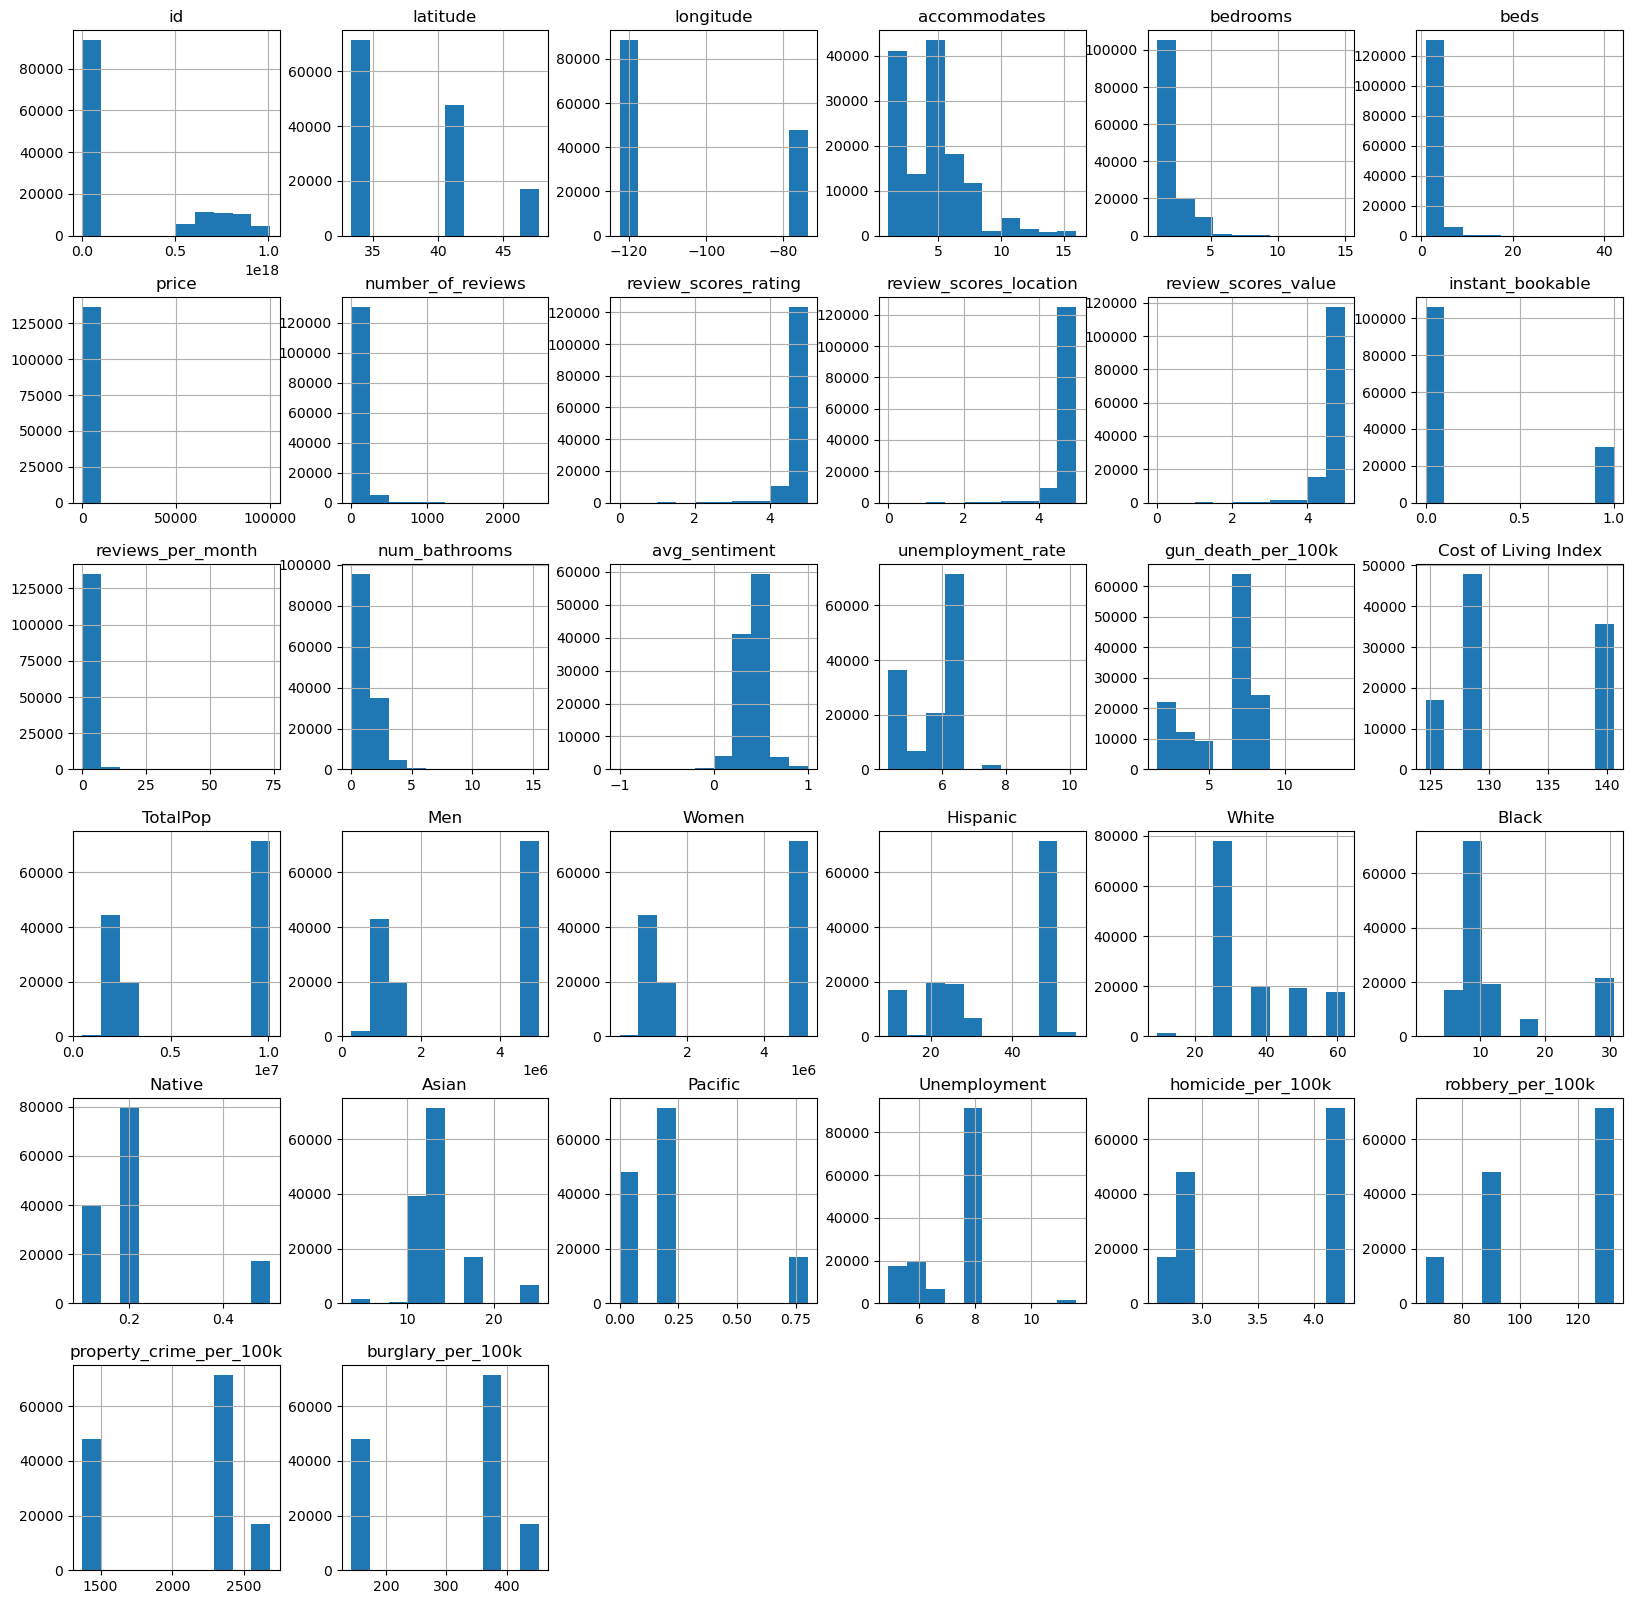

In [17]:
numerical_col.hist(figsize = (20,20))
plt.show()

### Correlations Between Features

C:\Users\12039\AppData\Local\Temp\ipykernel_1304\733004573.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = analysis_df.corr()


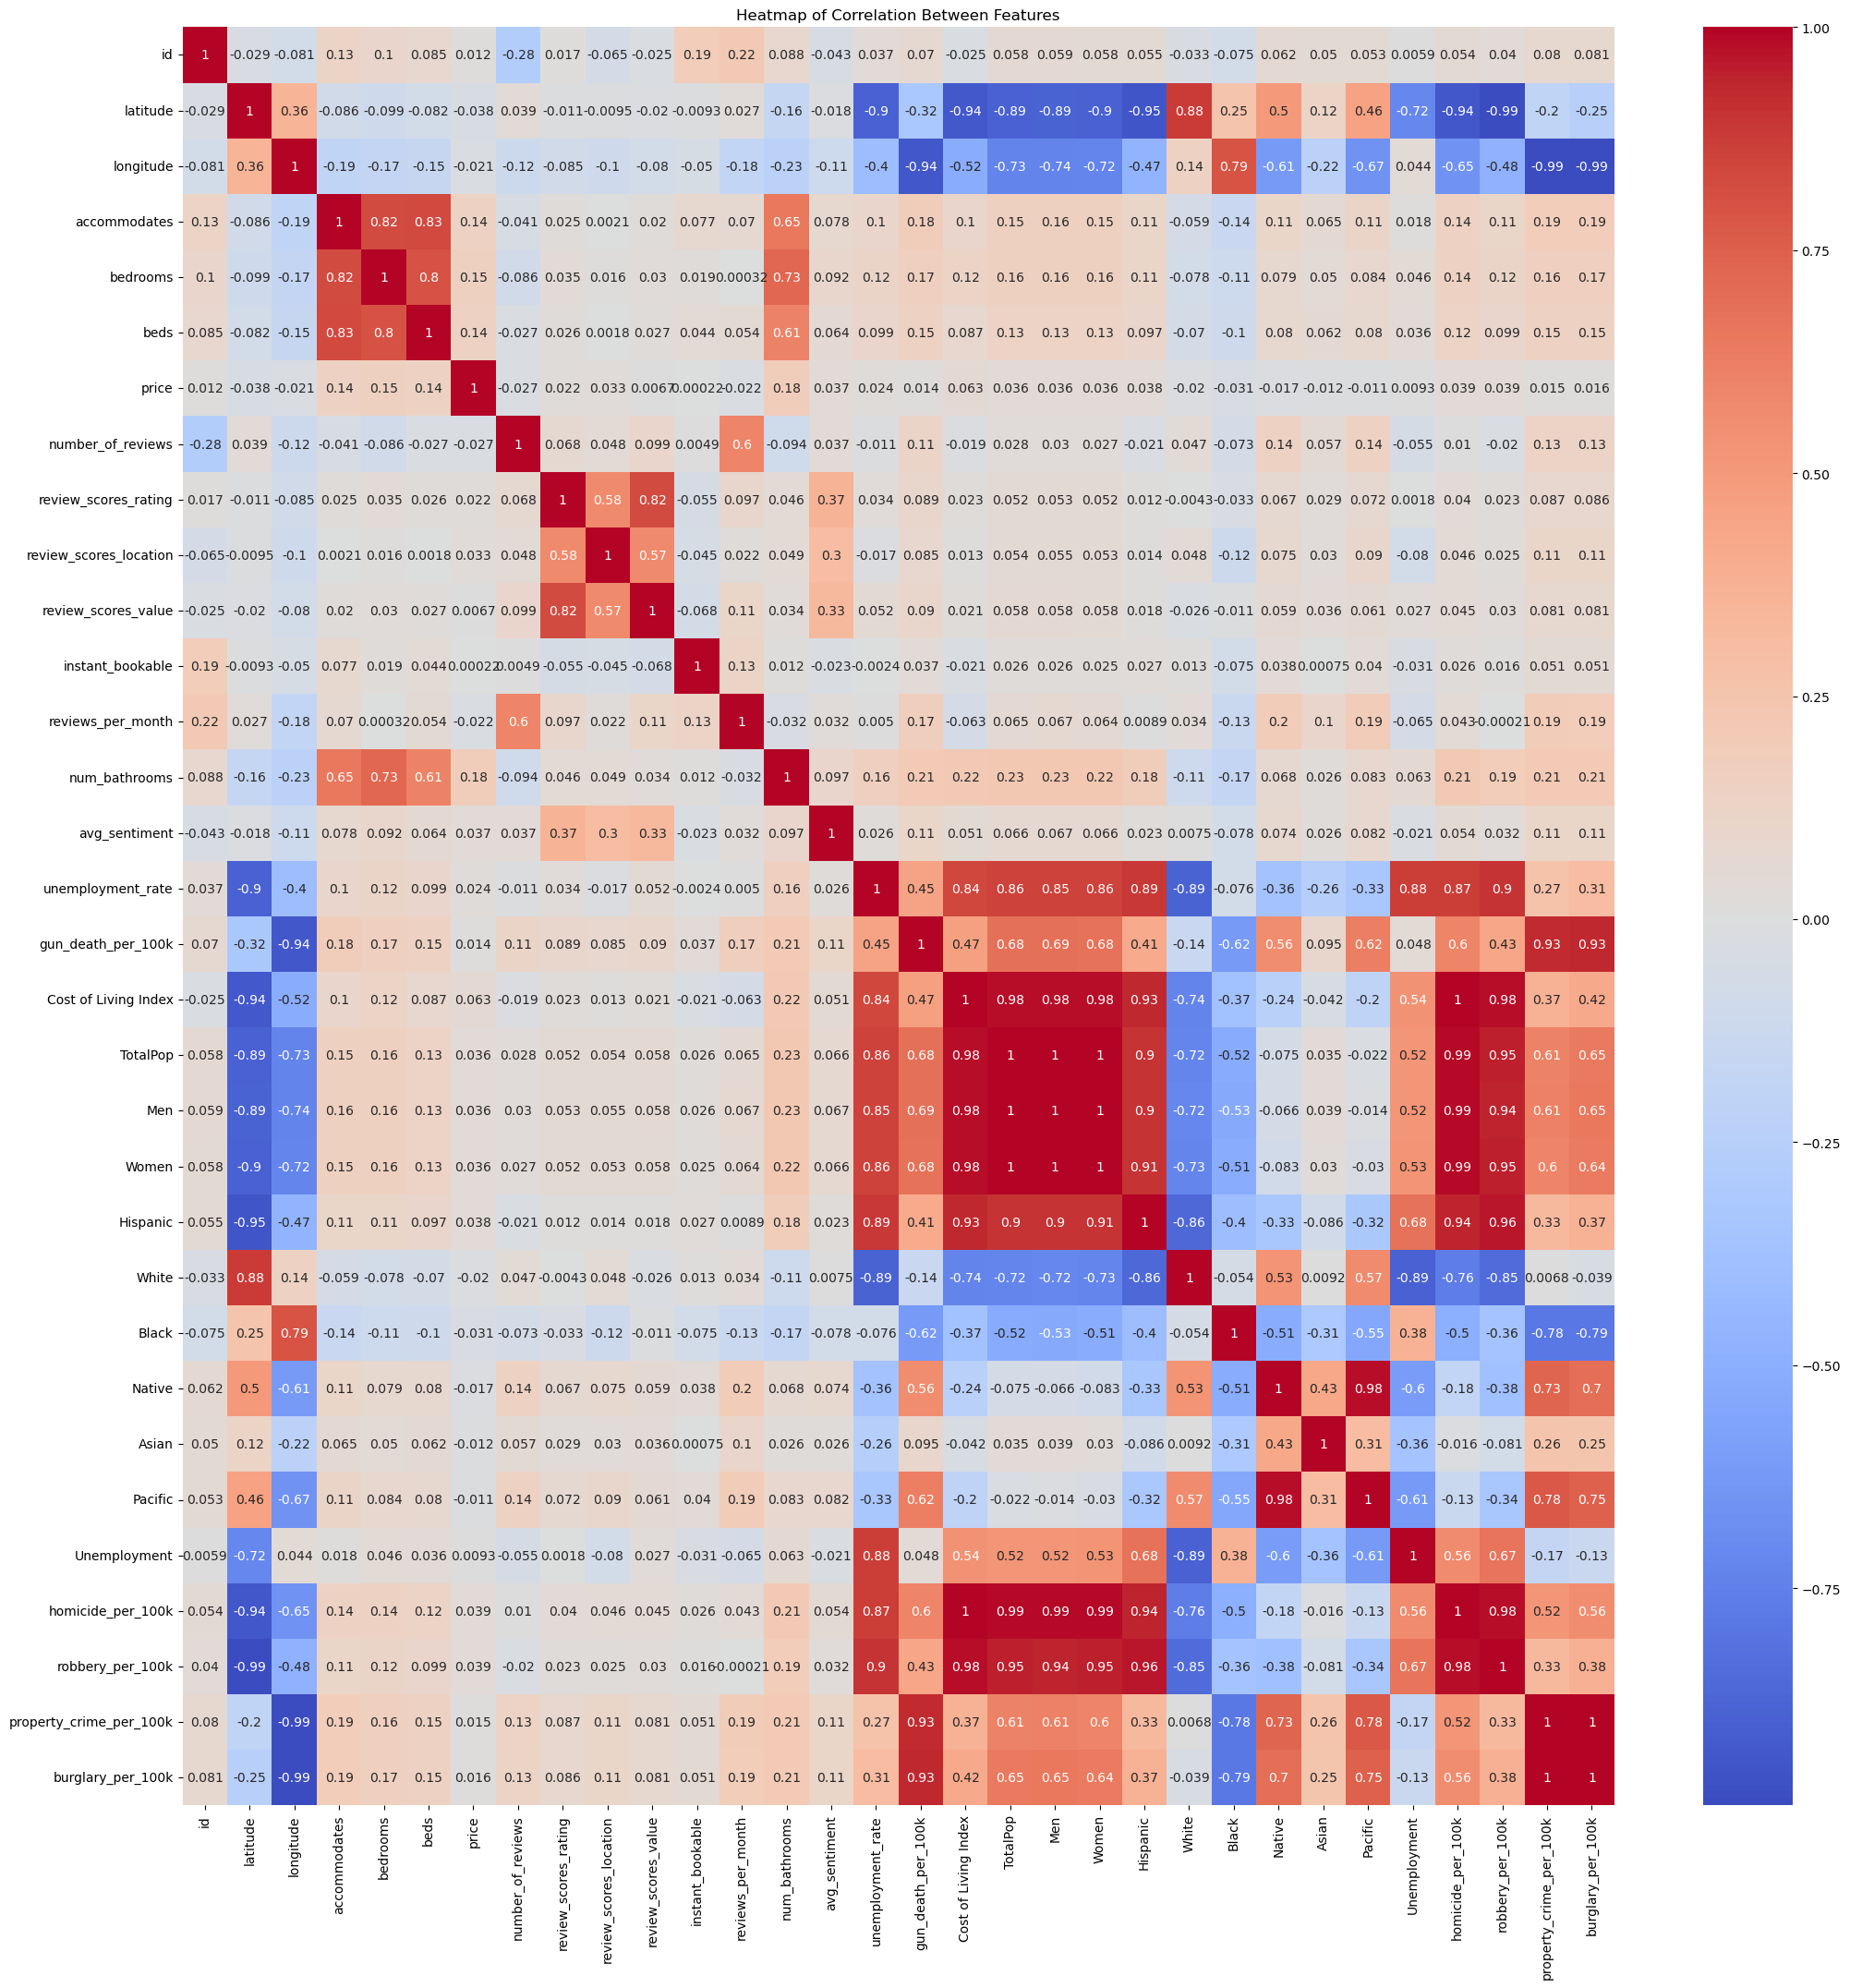

In [18]:
#  Correlations Between Features
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# set up correlation matrix
corr = analysis_df.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Features");

plt.show()

# Predictive Modeling using features that are statistically significant

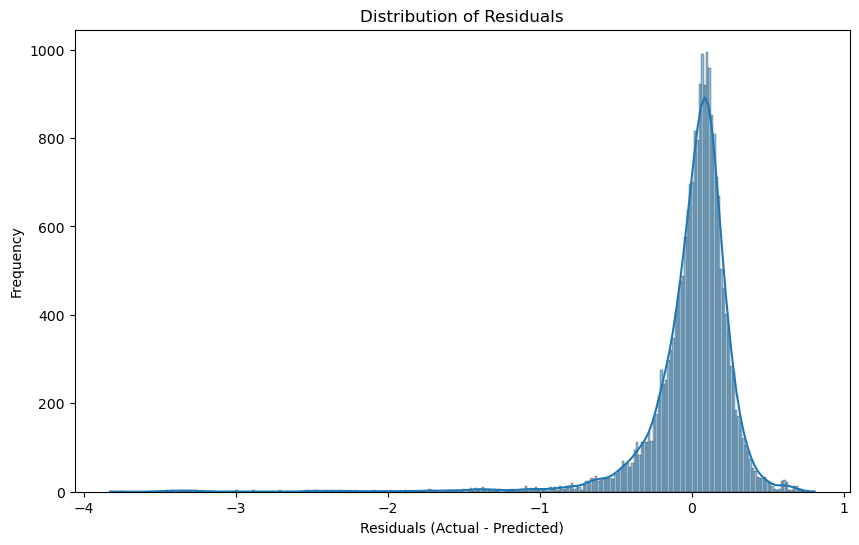

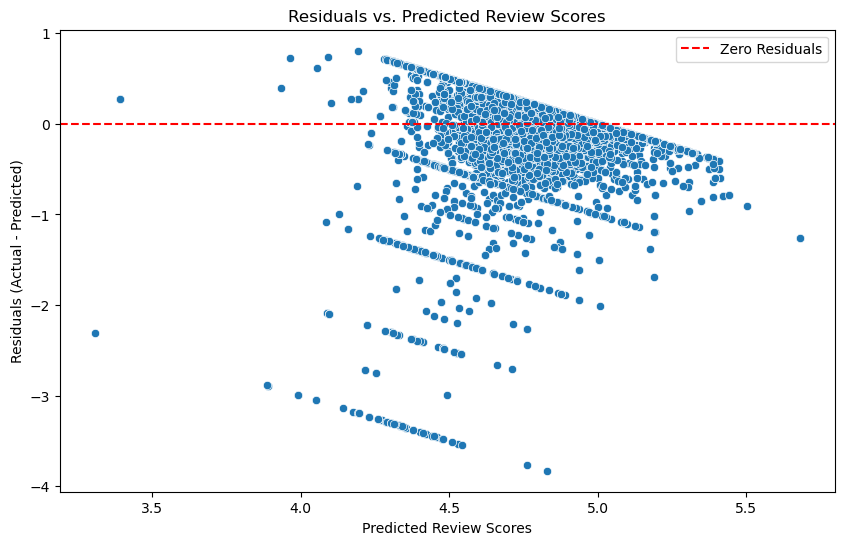

Mean Squared Error: 0.10613870365806725
R-squared: 0.1631567241171371


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


selected_columns = [
    'avg_sentiment', 'reviews_per_month', 'number_of_reviews', 'instant_bookable', 'TotalPop', 'num_bathrooms', 'bedrooms', 'unemployment_rate','price'
]

# Drop rows with missing values in the selected columns
model_data = analysis_df[selected_columns + ['review_scores_rating']].dropna()

# Split the data into training and testing sets
X = model_data[selected_columns]
y = model_data['review_scores_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Visualize the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Visualize the residuals against predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residuals')
plt.xlabel('Predicted Review Scores')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted Review Scores')
plt.legend()
plt.show()

# Evaluate the model using mean squared error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


The model shows a reasonable performance in predicting review scores, as indicated by a relatively small MSE.
However, the R² value suggests that a considerable portion of the variability in review scores is not explained by the selected features, highlighting the need for additional factors in the model or potential limitations in predicting review scores accurately.

**Summary:**

The model tends to overestimate review scores. In this case, the model consistently predicts values that are higher than the actual review scores.


**Cross-Validation Testing**

In [24]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Average cross-validation MSE
avg_cv_mse = -np.mean(cv_scores)
print(f'Average Cross-Validation MSE: {avg_cv_mse}')


Average Cross-Validation MSE: 0.10273205428287088


Average Cross-Validation MSE: 0.1027
The average MSE is relatively low, indicating that, on average, the model's predictions are close to the actual review scores across different cross-validation folds.

**Mean Absolute Error Testing**

In [25]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')


Mean Absolute Error (MAE): 0.18312337000661852


In summary, the model, on average, has a MAE of 0.1831, which suggests that it is making predictions that are close to the true review scores. 

### 1. Compute the correlation matrix: Calculate the correlation coefficients between all independent variables and the target variable (review_scores).

In [51]:
# List of columns to exclude from correlation analysis
non_numeric_columns = analysis_df.select_dtypes(exclude='number').columns

# Drop non-numeric columns before computing the correlation matrix
numeric_df = analysis_df.drop(columns=non_numeric_columns)

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Filter out features with 'review_scores' in their names
excluded_features = [col for col in correlation_matrix.columns if 'review_scores' in col]

# Compute the correlation of other columns with 'review_scores_rating'
correlation_with_target = correlation_matrix['avg_sentiment'].drop(excluded_features)

# Set a threshold for selecting highly correlated features
threshold = 0.1  # Modify as needed

# Identify features highly correlated with 'review_scores_rating'
highly_correlated_features = correlation_with_target[
    (correlation_with_target > threshold) | (correlation_with_target < -threshold)
].index.tolist()

# Exclude highly correlated features from the list of variables for prediction
variables_for_prediction = [
    col for col in correlation_with_target.index if col not in highly_correlated_features
]
print(highly_correlated_features)

['longitude', 'avg_sentiment', 'gun_death_per_100k', 'property_crime_per_100k', 'burglary_per_100k']


In [92]:

# Assuming 'analysis_df' is your DataFrame
# List of columns to exclude from correlation analysis
non_numeric_columns = analysis_df.select_dtypes(exclude='number').columns

# Drop non-numeric columns before computing the correlation matrix
numeric_df = analysis_df.drop(columns=non_numeric_columns)

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Filter out features with 'review_scores' in their names
excluded_features = [col for col in correlation_matrix.columns if 'review_scores' in col]

# Compute the correlation of other columns with 'review_scores_rating'
correlation_with_target = correlation_matrix['review_scores_rating'].drop(excluded_features)

# Set a threshold for selecting highly correlated features
threshold = 0.1  # Modify as needed

# Identify features highly correlated with 'review_scores_rating'
highly_correlated_features = correlation_with_target[
    (correlation_with_target > threshold) | (correlation_with_target < -threshold)
].index.tolist()

# Exclude highly correlated features from the list of variables for prediction
variables_for_prediction = [
    col for col in correlation_with_target.index if col not in highly_correlated_features
]
print(highly_correlated_features)


['avg_sentiment', 'year']


### 2. Select variables with high correlation: Identify the variables that have a relatively high absolute correlation with the target variable.

In [120]:
threshold = 0.5
relevant_variables = target_correlation[target_correlation > threshold].index.tolist()
print(relevant_variables)

NameError: name 'target_correlation' is not defined

### Use multiple regression to identify independent variables to predict review_scores_rating

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Assuming 'review_scores_rating' is the target variable
target_variable = 'review_scores_rating'

# Define independent variables
independent_variables = ['feature1', 'feature2', 'feature3']  # Replace with your chosen features

# Prepare data
X = cleaned_seattle_listings[independent_variables].values
y = cleaned_seattle_listings[target_variable].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Extract coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_
